# Recommending Web Articles (Feature Extraction & Clustering) 
By: MAHMOUD NAGY | MAY 2022

> **NOTE:**
> - We are going to use only **titles** in this notebook,
> - and will use **BOW** to extract features from text 

> - We will not use the article body, since it requires high computational power.

## Table of Contents
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

https://stats.stackexchange.com/questions/350339/how-to-split-data-into-training-and-testing-for-clustering <br>
https://scikit-learn.org/stable/modules/clustering.html

**Your team leader requests from you**
- build a classifier for the articles that can use in the recommendation. <br>
- In addition to, grouping the articles under each category into multiple groups, for example: <br>
Articles with the **Engineering** category will be grouped into **4 groups** each group with a dummy name e.g. group1, group2, ... etc. 
    - group1 will be mapped into software design 
    - group2 will be mapped into mobile development 

**you are responsible only for the grouping, they need only:** <br>
<font color='blue'> Engineering </font>
- group1 = [Article#1, Article#5, Article#9, ... etc.]
- group2 = [Article#2, Article#15, Article#91, ... etc.]
- group3 = [Article#10, Article#25, Article#90, ... etc.]
- group4 = [Article#11, Article#4, Article#6, ... etc.] 

<font color='blue'> and other categories. <br>
.<br>
.<br>
.</font>


**Feel free to choose your classification algorithm and all the pre-processing needed on the data.**

The team shares with you a JSON file for a group of categorized articles as you will divide those articles into 3 groups: training data, validating data, and testing data. 
To measure the accuracy of each algorithm, at this level you will measure the accuracy by the percent of matching only.

**What we expected:**
A GitHub repository includes:
- Your **Notebook** with the code you used in cleaning and analyzing the data + your model + evaluation.
- **JSON file** for the clusters output (to each category).
- **PDF file** for the evaluation report that will be delivered to the leader (Make sure to mention all your steps in visualizing your results).

<a id='load'></a>
## Step 0: Load the Data
<ul>
    <li><a href="#load"><b>Step 0: Load the Data</b></a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

In [1]:
from time import time
import pandas as pd
import numpy as np 
import json
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import re
import regex

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Fix random seed
np.random.seed(42)

import importlib
importlib.reload(helper)

<module 'helper' from '/Users/mnagy99/jupyter/Knowledge Officer Assignment/Recommending Web Articles/helper.py'>

In [2]:
df = pd.read_csv('clean_data.csv')
print(df.shape)
df.head()

(2454, 5)


,body,title,category,title_clean,body_clean
0,The Founder Institute’s “Startup Tips and Tric...,Make Your Entrepreneurial Journey Sufficientl...,Startups & Business,make entrepreneurial journey sufficiently epic...,founder institute startup tips tricks series g...
1,JAXenter: Have microservices helped you achiev...,"""The size of a microservice is the size of the...",Engineering,size microservice size team building,jaxenter microservices helped achieve goals av...
2,Interview with Fabian Reinartz and Björn Raben...,"""Transition to microservices while running und...",Engineering,transition microservices running full steam easy,interview fabian reinartz bjrn rabenstein soun...
3,Why do many companies sprint from initial conc...,01 MarGo to Market Fit: Achieving Sustainable ...,Startups & Business,margo market achieving sustainable growth,many companies sprint initial concept product ...
4,1. Advisors\n\nChoose experienced advisors ear...,1. Advisors,Startups & Business,advisors,advisors choose experienced advisors early inc...


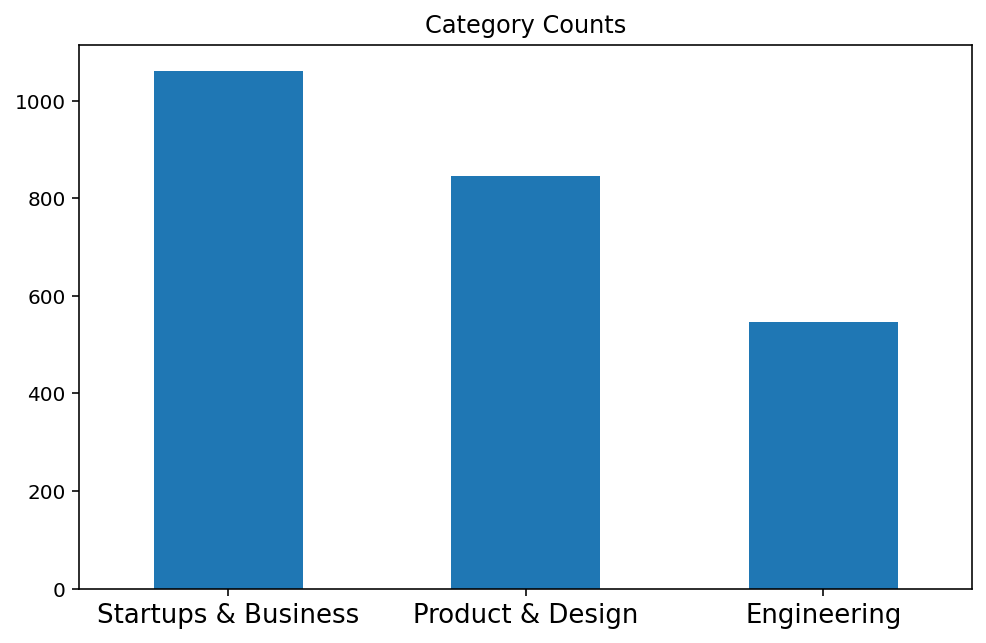

In [3]:
df.category.value_counts().plot(kind = 'bar', figsize = (8,5)  );
plt.title('Category Counts');
plt.xticks(rotation=0, size=13);

In [4]:
df.category.value_counts()

Startups & Business    1061
Product & Design        846
Engineering             547
Name: category, dtype: int64

<br>

**Add a Word Count Column**

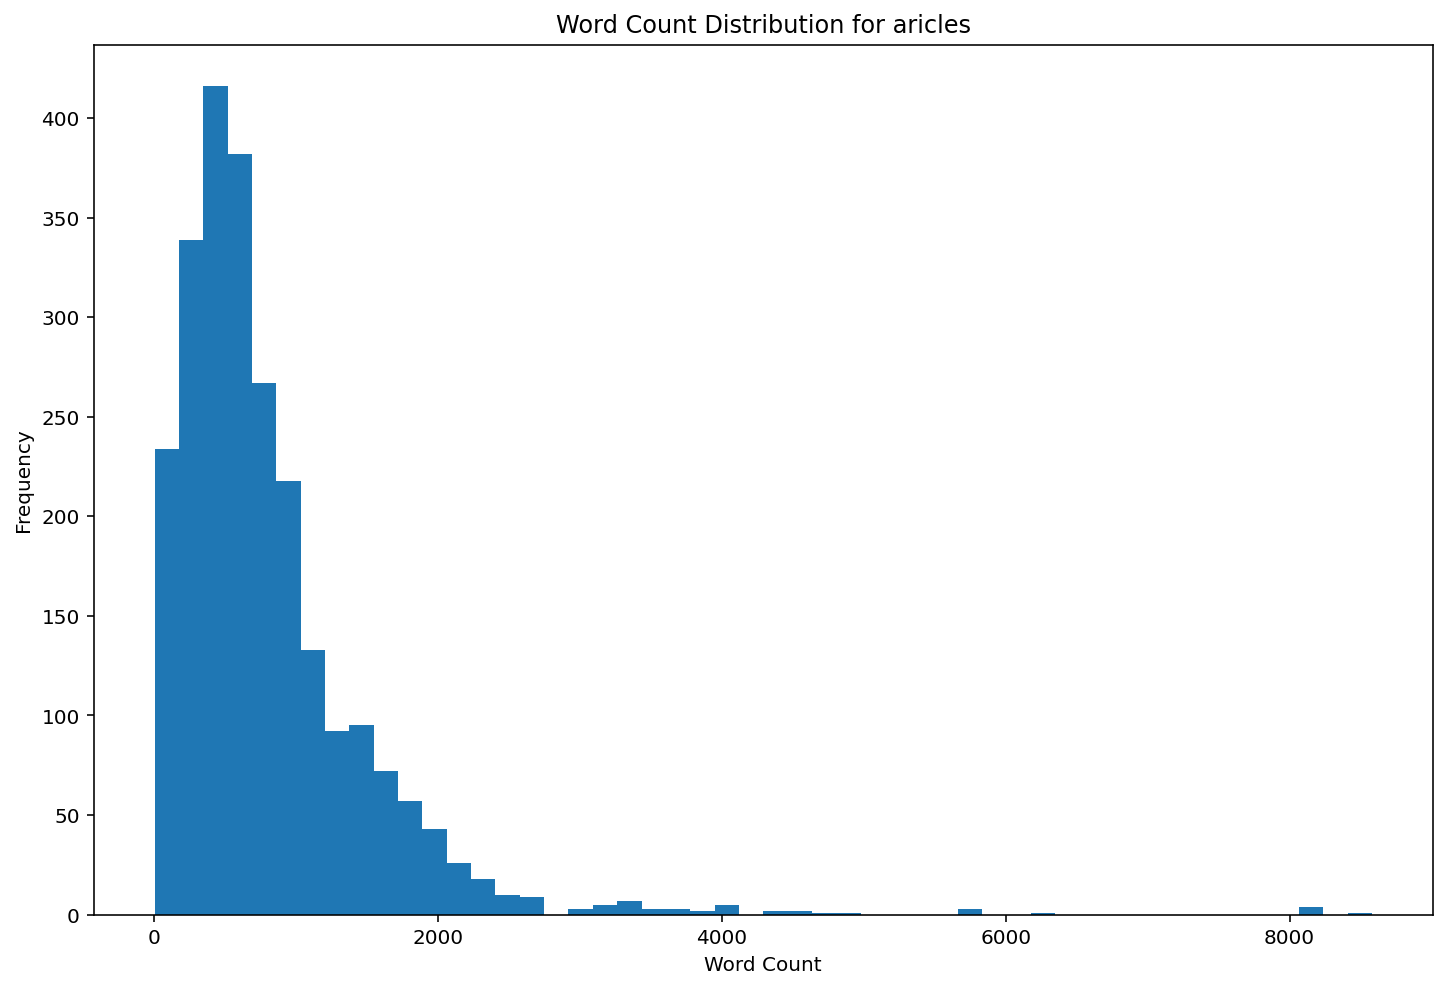

In [5]:
# Calculating the word count for articles
df['n_words'] = df['body_clean'].apply(lambda x: len(str(x).split()))# Plotting the word count
df['n_words'].plot(kind='hist', bins = 50, figsize = (12,8),
                   title='Word Count Distribution for aricles');
plt.xlabel('Word Count');

In [6]:
# Drop the words count column
df.drop(columns='n_words', inplace=True)

<br>

<a id='extract'></a>
## Step 1: Extract Features From Text
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract"><b>Step 1: Extract Features From Text</b></a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

https://www.geeksforgeeks.org/feature-extraction-techniques-nlp/ <br>
**https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76**

### Bag of Words:
I think this model will work well if we used only titles
- The BoW model is used in document classification, where each word is used as a feature for training the classifier. There are 3 steps while creating a BoW model :

    - **The first step** is text-preprocessing which involves: converting the entire text into lower case characters. removing all punctuations and unnecessary symbols.
    - **The second step** is to create a vocabulary of all unique words from the corpus. 
    - **In the third step**, we create a matrix of features by assigning a separate column for each word, while each row corresponds to a review. This process is known as Text Vectorization. Each entry in the matrix signifies the presence(or absence) of the word in the review. We put 1 if the word is present in the review, and 0 if it is not present.

<font color='red'> A major drawback in using this model is that the order of occurence of words is lost, as we create a vector of tokens in randomised order. However, we can solve this problem by considering N-grams (mostly bigrams) instead of individual words (i.e. unigrams). This can preserve local ordering of words. </font>

### N-grams (mostly bigrams)
- <font color='red'>However, this table will come out to be very large, as there can be a lot of possible bigrams by considering all possible consecutive word pairs. </font>
- <font color='red'>Also, using N-grams can result in a huge sparse(has a lot of 0’s) matrix, if the size of the vocabulary is large, making the computation really complex!! </font>
- **Thus, we have to remove a few N-grams based on their frequency.**
    - Like, we can always remove **high-frequency N-grams**, because they appear in almost all documents. These high-frequency N-grams are generally articles, determiners, etc. most commonly called as **StopWords**.
    - Similarly, we can also remove **low frequency N-grams** because these are really rare(i.e. generally appear in 1 or 2 reviews)!! These types of N-grams are generally **typos** (or typing mistakes).
- Generally, medium frequency N-grams are considered as the most ideal.
- However, there are some N-grams which are really rare in our corpus but can highlight a specific issue.
    - Review: “Wi-Fi breaks often”.
    - Here, the N-gram ‘Wi-Fi breaks can’t be too frequent, but it highlights a major problem that needs to be looked upon.
    
<font color='red'>Our BoW model would not capture such N-grams since its frequency is really low. To solve this type of problem, we need another model i.e. TF-IDF Vectorizer, which we will study next. </font>

### TF-IDF Vectorizer : 
I think this would be the best method if we used the body and not the titles
- TF-IDF stands for term frequency-inverse document frequency.
- **It highlights a specific issue which might not be too frequent in our corpus but holds great importance.** 
- The TF–IFD value **increases** proportionally to the number of times a word appears in the document 
- and **decreases** with the number of documents in the corpus that contain the word. It is composed of 2 sub-parts, which are :
    - Term Frequency (TF)
    - Inverse Document Frequency (IDF)

### TF-IDF Vectorizer : 
I think this would be the best method if we used the body and not the titles

https://stackoverflow.com/questions/34725726/is-it-possible-apply-pca-on-any-text-classification

In [7]:
# # calculating tf-idf values
# from sklearn.feature_extraction.text import TfidfVectorizer  

# # (1, 2) means unigrams and bigrams
# tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df = 1, stop_words='english')
# features = tfidf.fit_transform(df.title_clean)
  
# df_features = pd.DataFrame(features.todense(), columns = tfidf.get_feature_names_out())   
# print(df_features.shape)
# df_features.head()

In [8]:
# df_features[(df_features != 0).any(axis=1)]

In [9]:
# 'your' in df_features.columns

<br>

### Bag of Words : 
I think this model will work well if we used only titles

In [10]:
# Implementing Bag of Words in scikit-learn

from sklearn.feature_extraction.text import CountVectorizer

t0 = time()
count_vector = CountVectorizer(stop_words='english')
features_array = count_vector.fit_transform(df.title_clean).toarray()
frequency_matrix = pd.DataFrame(features_array, columns=count_vector.get_feature_names())
print(time()-t0)
print(frequency_matrix.shape)
frequency_matrix.head()

0.10331177711486816
(2454, 3358)


/Users/mnagy99/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aarron,able,abstraction,abstractions,abstractive,abundance,abuse,academia,accelerate,accelerates,...,zara,zdnet,zero,zhuo,zillow,zola,zombie,zones,zuckerberg,zuul
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
'your' in frequency_matrix.columns

False

In [12]:
'"' in frequency_matrix.columns

False

In [13]:
nltk.word_tokenize('01 margo to market fit: achieving sustainable growth')

['01',
 'margo',
 'to',
 'market',
 'fit',
 ':',
 'achieving',
 'sustainable',
 'growth']

In [14]:
# # Implementing Bag of Words Manually
# # By creating a list of dictionaries with words and their counts in each text

# def bag_of_words(text):
#     word2count = {}
#     words = nltk.word_tokenize(text) 
#     for word in words: 
#         if word not in word2count.keys(): 
#             word2count[word] = 1
#         else: 
#             word2count[word] += 1
            
#     return word2count

In [15]:
# dict_list = []
# for text in df.title:
#     dict_list.append(bag_of_words(text))

# frequency_matrix = pd.DataFrame(dict_list) 
# frequency_matrix.fillna(0, inplace=True)
# print(frequency_matrix.shape)
# frequency_matrix.head()

In [16]:
# frequency_matrix[(frequency_matrix != 0).any(axis=1)]

In [17]:
# 'your' in frequency_matrix.columns

<br>

**Drop StopWords, numeric, and not-alpha Columns**

**There are two methods:**
- We can add a clean_text column in the data, then use string methods --> **DONE**
- or we can extract features, then drop the unwanted columns

In [18]:
# columns_to_drop = []
# for col in frequency_matrix.columns:
#     if col in stop_words:
#         columns_to_drop.append(col)
#     if not col.isalpha():
#         columns_to_drop.append(col)
        
# len(columns_to_drop)

In [19]:
# frequency_matrix.drop(columns=columns_to_drop, inplace=True)
# print(frequency_matrix.shape)
# frequency_matrix.head(1)

<br>

<a id='reduce'></a>
## Step 2:  Dimensionality Reduction
1. Feature Selection
2. Feature Extraction (PCA) 

<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce"><b>Step 2: Dimensionality Reduction</b></a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

## 1. Feature Selection

**Drop Correlated Columns** <br>
https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

In [20]:
# # Identify correlations between numeric features
# t0 = time()
# columns_to_drop = helper.get_correlated_columns(df_features, 0.95)
# print((time()-t0)/60)
# print(len(columns_to_drop))
# # columns_to_drop

In [23]:
# X = df_features.drop(columns=columns_to_drop)
# print(X.shape)
# X.head(1)

In [24]:
X = frequency_matrix.copy()

In [25]:
X.columns[:100]

Index(['aarron', 'able', 'abstraction', 'abstractions', 'abstractive',
       'abundance', 'abuse', 'academia', 'accelerate', 'accelerates',
       'accelerator', 'acceptance', 'access', 'accessibility', 'accessible',
       'accident', 'accomplishing', 'according', 'account', 'accounting',
       'accurate', 'achieve', 'achieved', 'achieving', 'acing', 'acoustic',
       'acquire', 'acquired', 'acquiring', 'acquisition', 'action',
       'actionable', 'actions', 'activation', 'active', 'acton', 'actually',
       'adam', 'adams', 'adaptability', 'addict', 'addictive', 'adding',
       'address', 'addresses', 'addressing', 'adeo', 'adjective',
       'adjustments', 'adobe', 'adopt', 'adopters', 'adoption', 'adriaenssens',
       'advanced', 'advantage', 'adventures', 'adversarial', 'advertising',
       'advice', 'advisor', 'advisors', 'advisory', 'aesthetics', 'affects',
       'affordable', 'afraid', 'afterward', 'agencies', 'agile', 'agnostic',
       'agreement', 'agreements', 'ahe

> **NOTE:**
>- I wanted to keep columns which contain alphanumeric, I believed some of them would be helpful in the clustering,
> - But, I decided to remove them since they contained a lot of misleading features

In [26]:
# # Drop Numeric Columns
# columns_to_drop = []
# for col in X.columns:
#     if col.isdigit():
#         columns_to_drop.append(col)
        
# print(len(columns_to_drop))

In [27]:
# X.drop(columns=columns_to_drop, inplace=True)
# print(X.shape)
# X.head(1)

In [28]:
y = df.category.map({'Engineering': 0, 'Product & Design': 1, 'Startups & Business':2})
len(y)

2454

<br>

**https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features**

## 2. Feature Extraction 
PCA --> Principal Component Analysis

**All Data (Without Separation)**

> **NOTE:**
> - <font color='red'> **Don't scale features after BOW or TF-IDF** </font>
> - <font color='red'> We scale features to make sure all of them are treated the same (to avoid bias), </font>
> - <font color='red'> as the model understand larger values as more importat, **which is actually the case here!** </font>
> - <font color='red'> BOW or TF-IDF give higher values to most repeated words, which are more important </font>

https://stats.stackexchange.com/questions/65047/normalizing-term-frequency-for-document-clustering

TF/IDF usually is a two-fold normalization.

First, each document is normalized to length 1, so there is no bias for longer or shorter documents. This equals taking the relative frequencies instead of the absolute term counts. This is "TF".

Second, IDF then is a cross-document normalization, that puts less weight on common terms, and more weight on rare terms, by normalizing (weighting) each word with the inverse in-corpus frequency. Here it does not matter whether you use the absolute or relative frequency, as this amounts just to a constant factor across all vectors, so you will get different distances, but only by a constant factor (the corpus size).

In [29]:
# # Apply feature scaling to the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(X)

# X_scaled = pd.DataFrame(data_scaled, columns=list(X.columns))
# print(X_scaled.shape)
# X_scaled.head()

In [30]:
# X_scaled.describe() #Mean=0, Std=1

In [31]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X) # Don't scale features after bow or tf-idf

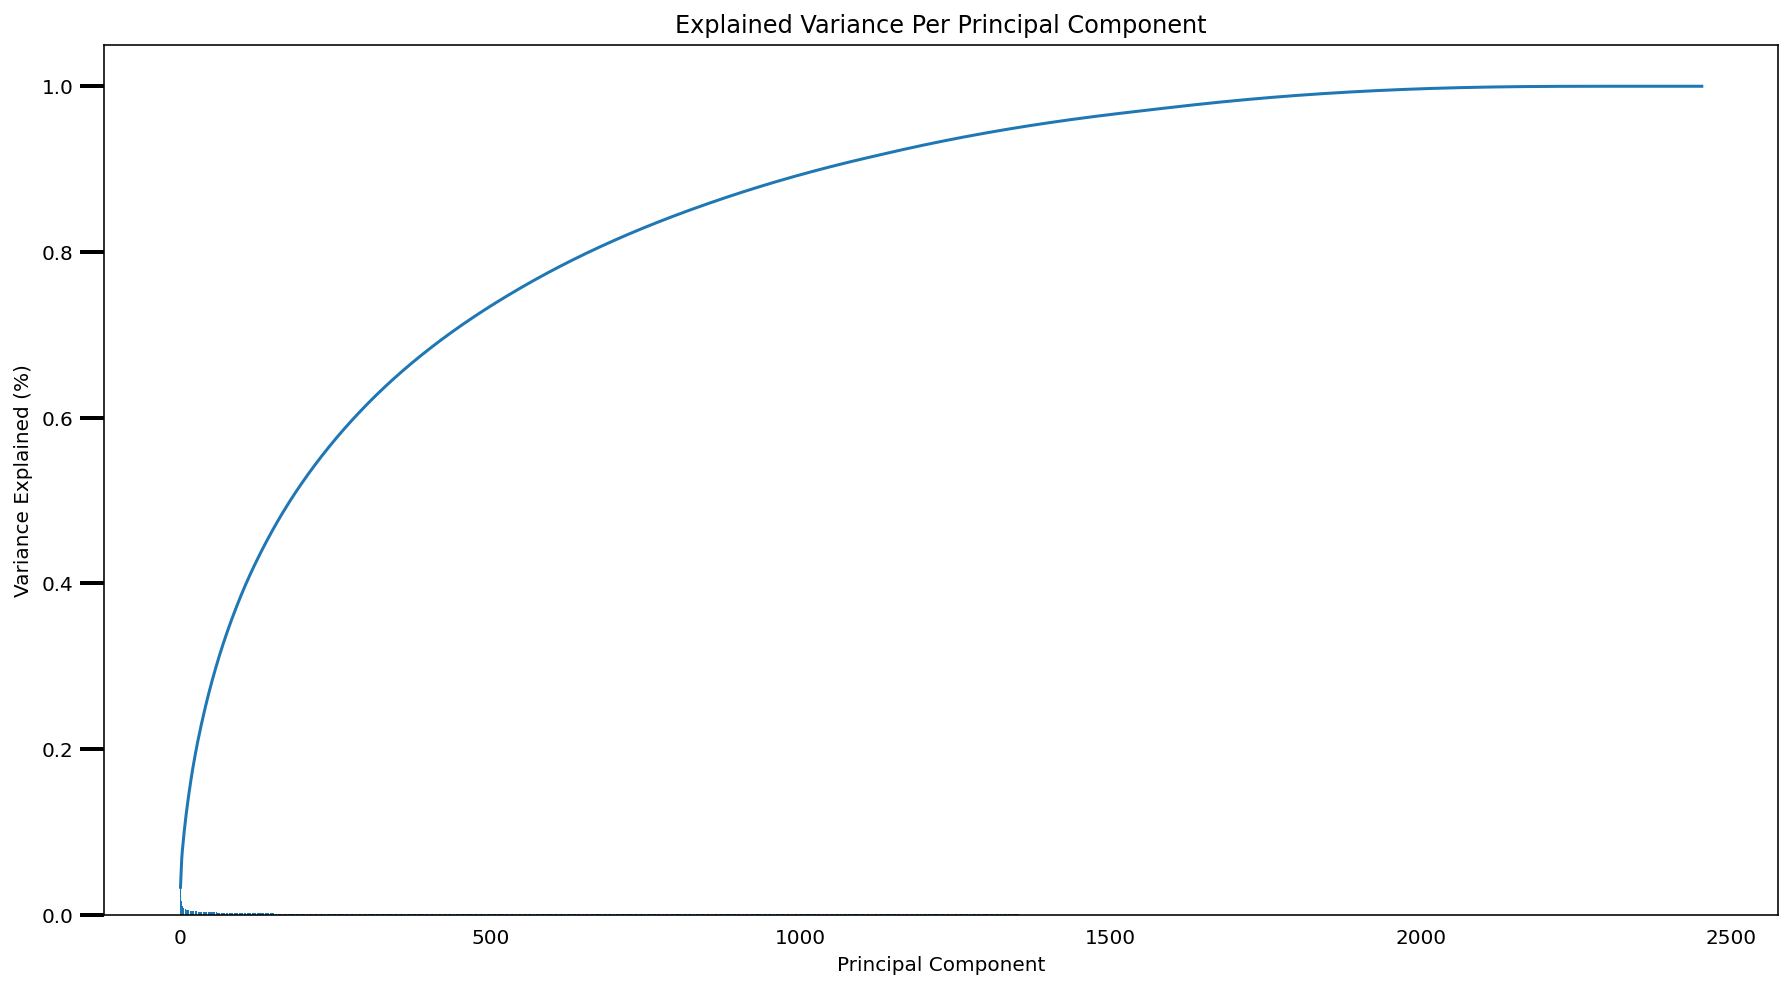

In [32]:
# To get the number of pca components to use (highest variance)
helper.scree_plot(pca)

In [33]:
# Re-apply PCA to the data while selecting for number of components to retain.

num_components=len(pca.explained_variance_ratio_)
vals = pca.explained_variance_ratio_

cumvals = np.cumsum(vals)
ind = next(x[0] for x in enumerate(cumvals) if x[1] > 0.8)
num_comps = ind+1
num_comps

print(f'{num_comps} PCA components --> allow us to capture {round(cumvals[num_comps-1]*100,2)}% of data variability')

660 PCA components --> allow us to capture 80.0% of data variability


In [34]:
pca = PCA(n_components=num_comps)
X_pca = pca.fit_transform(X)

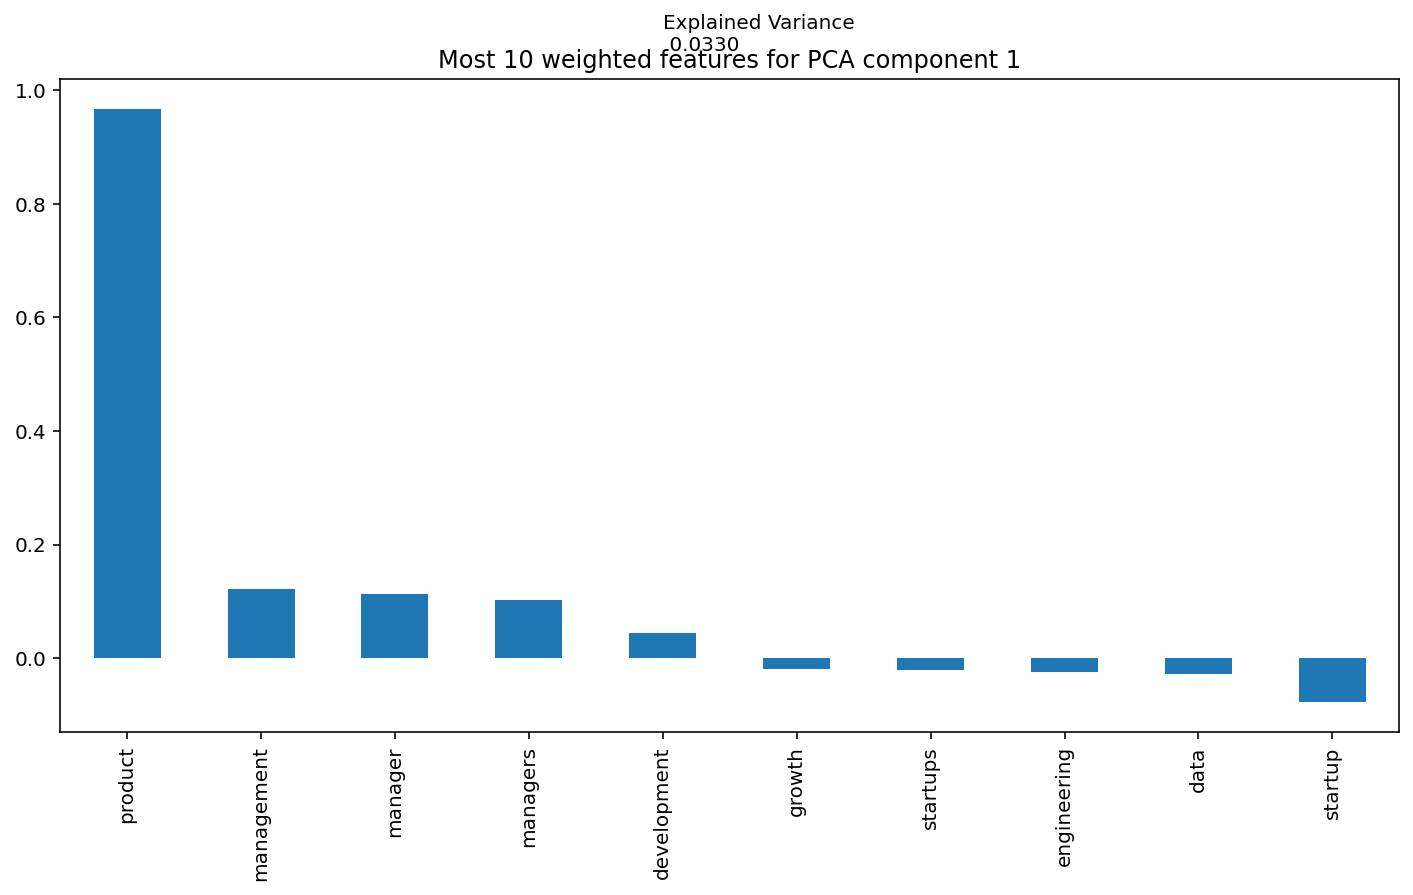

product        0.9664
management     0.1214
manager        0.1127
managers       0.1018
development    0.0446
growth        -0.0194
startups      -0.0216
engineering   -0.0235
data          -0.0271
startup       -0.0773
Name: 0, dtype: float64


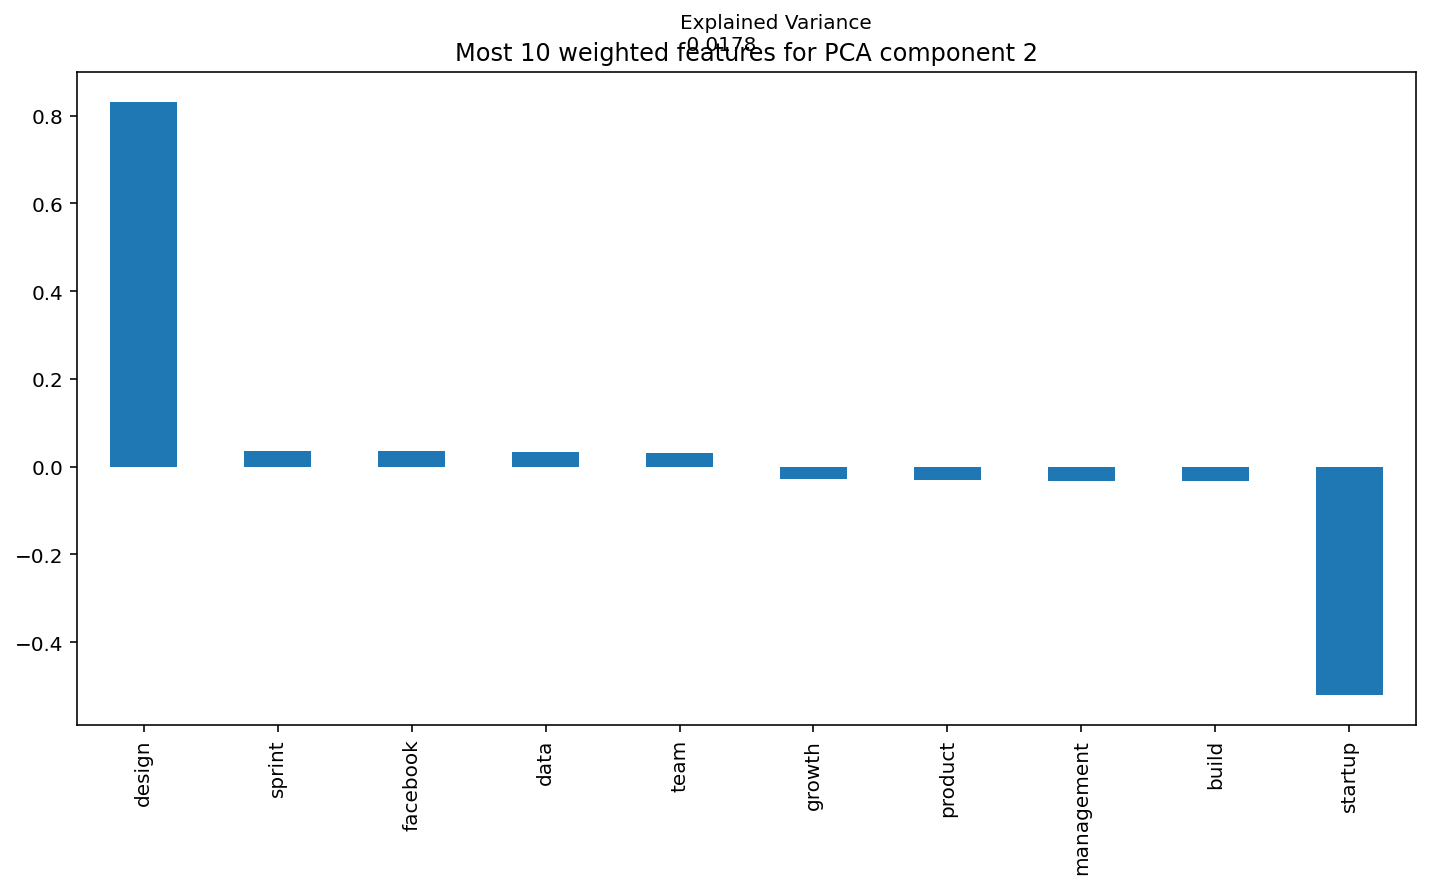

design        0.8312
sprint        0.0357
facebook      0.0355
data          0.0342
team          0.0307
growth       -0.0279
product      -0.0306
management   -0.0316
build        -0.0322
startup      -0.5206
Name: 1, dtype: float64


In [35]:
# Interpret Principal Components

res = helper.pca_results(X, pca, 1, 5)
print(res)

res = helper.pca_results(X, pca, 2, 5)
print(res)

<br>

https://stats.stackexchange.com/questions/363024/unsupervised-classification-vs-supervised-classification-when-data-labels-are-kn <br>
**https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features**

<a id='supervised'></a>
## Step 3: Build a Supervised Learning Model (Classifier)

<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised"><b>Step 3: Build a Supervised Learning Model</b></a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

> The accuracy score seems to be a good metric for this problem,
> as it's not critical if we misclassified an article.

In [36]:
# # Default XGBClassifier

# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
#               min_child_weight=1, missing=nan, monotone_constraints='()',
#               n_estimators=100, n_jobs=12, num_parallel_tree=1,
#               objective='multi:softprob', random_state=0, reg_alpha=0,
#               reg_lambda=1, scale_pos_weight=None, subsample=1,
#               tree_method='exact', use_label_encoder=False,
#               validate_parameters=1, verbosity=None)

In [37]:
### Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
from xgboost import XGBClassifier

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [39]:
t0 = time()
# build a classifier
clf_xgb = XGBClassifier(n_estimators=220, random_state=42)
clf_xgb.fit(X_train, y_train)
xgb_preds = clf_xgb.predict(X_test)

helper.print_metrics(y_test, xgb_preds, 'XGBClassifier')
print(time()-t0)

Accuracy score for XGBClassifier : 0.7596741344195519
45.87855505943298


In [140]:
t0 = time()
# build a classifier
clf_rf = RandomForestClassifier(n_estimators=150, random_state=42) # default --> n_estimators=100
clf_rf.fit(X_train, y_train)
rf_preds = clf_rf.predict(X_test)

helper.print_metrics(y_test, rf_preds, 'RandomForestClassifier')
print(time()-t0)

Accuracy score for RandomForestClassifier : 0.7230142566191446
4.36506199836731


**Without PCA**

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
t0 = time()
# build a classifier
clf_xgb = XGBClassifier(n_estimators=220, random_state=42) # default --> n_estimators=100
clf_xgb.fit(X_train, y_train)
xgb_preds = clf_xgb.predict(X_test)

helper.print_metrics(y_test, xgb_preds, 'XGBClassifier')
print(time()-t0)

Accuracy score for XGBClassifier : 0.7596741344195519
114.44329404830933


In [129]:
t0 = time()
# build a classifier
clf_rf = RandomForestClassifier(n_estimators=70, random_state=42) # default --> n_estimators=100
clf_rf.fit(X_train, y_train)
rf_preds = clf_rf.predict(X_test)

helper.print_metrics(y_test, rf_preds, 'RandomForestClassifier')
print(time()-t0) 

Accuracy score for RandomForestClassifier : 0.7393075356415478
2.0713489055633545


**Model Tuning**

In [44]:
start = time()
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

# Initialize the classifier
clf = RandomForestClassifier() # default --> n_estimators=100

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {
#     "max_depth": [3,5,8,10,None],
    "n_estimators": [200, 220, 250],
#     "max_features":["log2","sqrt", None],
#     "min_samples_split": list(range(2, 11)),
#     "min_samples_leaf": list(range(1, 11)), 
#     "learning_rate": [0.01, 0.05, 0.1],
    }

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(accuracy_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
(time() - start) / 60

Unoptimized model
------
Accuracy score on testing data: 0.7332

Optimized Model
------
Final accuracy score on the testing data: 0.7352


1.2402045806248982

In [45]:
best_clf

RandomForestClassifier(n_estimators=200)

<br>

https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features

<a id='cluster'></a>
## Step 3: Filter & Cluster

<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster"><b>Step 4: Filter & Cluster</b></a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

><ul>
 <li><a href="#eng">Engineering</a></li>
 <li><a href="#product">Product & Design</a></li>
 <li><a href="#business">Startups & Business</a></li>
 </ul>

In [46]:
df.category.value_counts()

Startups & Business    1061
Product & Design        846
Engineering             547
Name: category, dtype: int64

In [47]:
print('category' in X.columns)
'article_category' in X.columns

True


False

In [48]:
# X.drop(columns='article_category', inplace=True)

In [49]:
# Add the category column to use in filtering
X_to_filter = X.copy()
X_to_filter.insert(0, 'article_category', df.category)
X_to_filter.head(1)

,article_category,aarron,able,abstraction,abstractions,abstractive,abundance,abuse,academia,accelerate,...,zara,zdnet,zero,zhuo,zillow,zola,zombie,zones,zuckerberg,zuul
0,Startups & Business,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id='eng'></a> 
### Feature Extraction (Engineering)
<ul>
<li><a href="#eng"><b>Engineering</b></a></li>
<li><a href="#product">Product & Design</a></li>
<li><a href="#business">Startups & Business</a></li>
</ul>

> **NOTE:**
> - Before we scale data and apply Feature Extraction, we will separate the articles by category.

In [50]:
df_eng = X_to_filter.query(" article_category == 'Engineering'")
X_eng = df_eng.iloc[:, 1:]
X_eng.reset_index(inplace=True, drop=True)
print(X_eng.shape)
X_eng.head(3)

(547, 3358)


,aarron,able,abstraction,abstractions,abstractive,abundance,abuse,academia,accelerate,accelerates,...,zara,zdnet,zero,zhuo,zillow,zola,zombie,zones,zuckerberg,zuul
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# # Apply feature scaling to the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_eng_scaled = scaler.fit_transform(X_engineering) #Mean=0, Std=1

# X_eng_scaled = pd.DataFrame(data_eng_scaled, columns=list(X_engineering.columns))
# print(X_eng_scaled.shape)
# X_eng_scaled.head(1)

In [52]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
X_eng_pca = pca.fit_transform(X_eng)

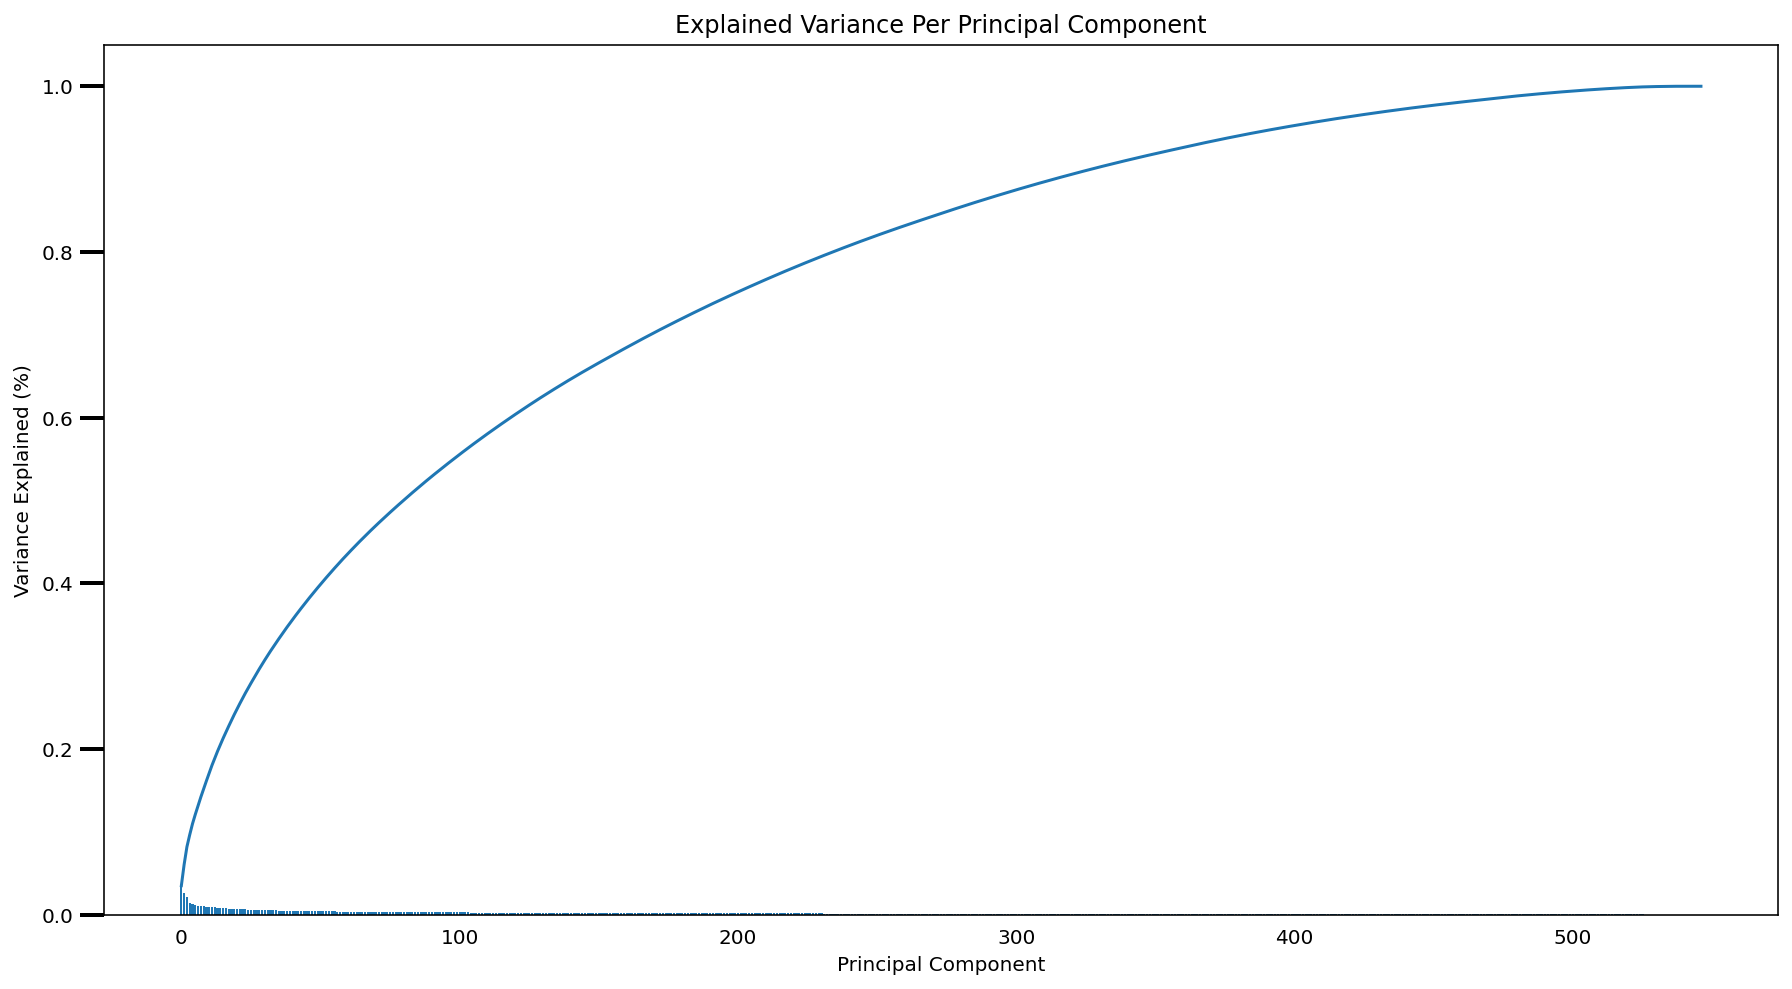

In [53]:
# To get the number of pca components to use (highest variance)
helper.scree_plot(pca)

In [54]:
# Re-apply PCA to the data while selecting for number of components to retain.

num_components=len(pca.explained_variance_ratio_)
vals = pca.explained_variance_ratio_

cumvals = np.cumsum(vals)
ind = next(x[0] for x in enumerate(cumvals) if x[1] > 0.8)
num_comps = ind+1
num_comps

print(f'{num_comps} PCA components --> allow us to capture {round(cumvals[num_comps-1]*100,2)}% of data variability')

236 PCA components --> allow us to capture 80.12% of data variability


In [55]:
pca = PCA(n_components=num_comps)
X_eng_pca = pca.fit_transform(X_eng)

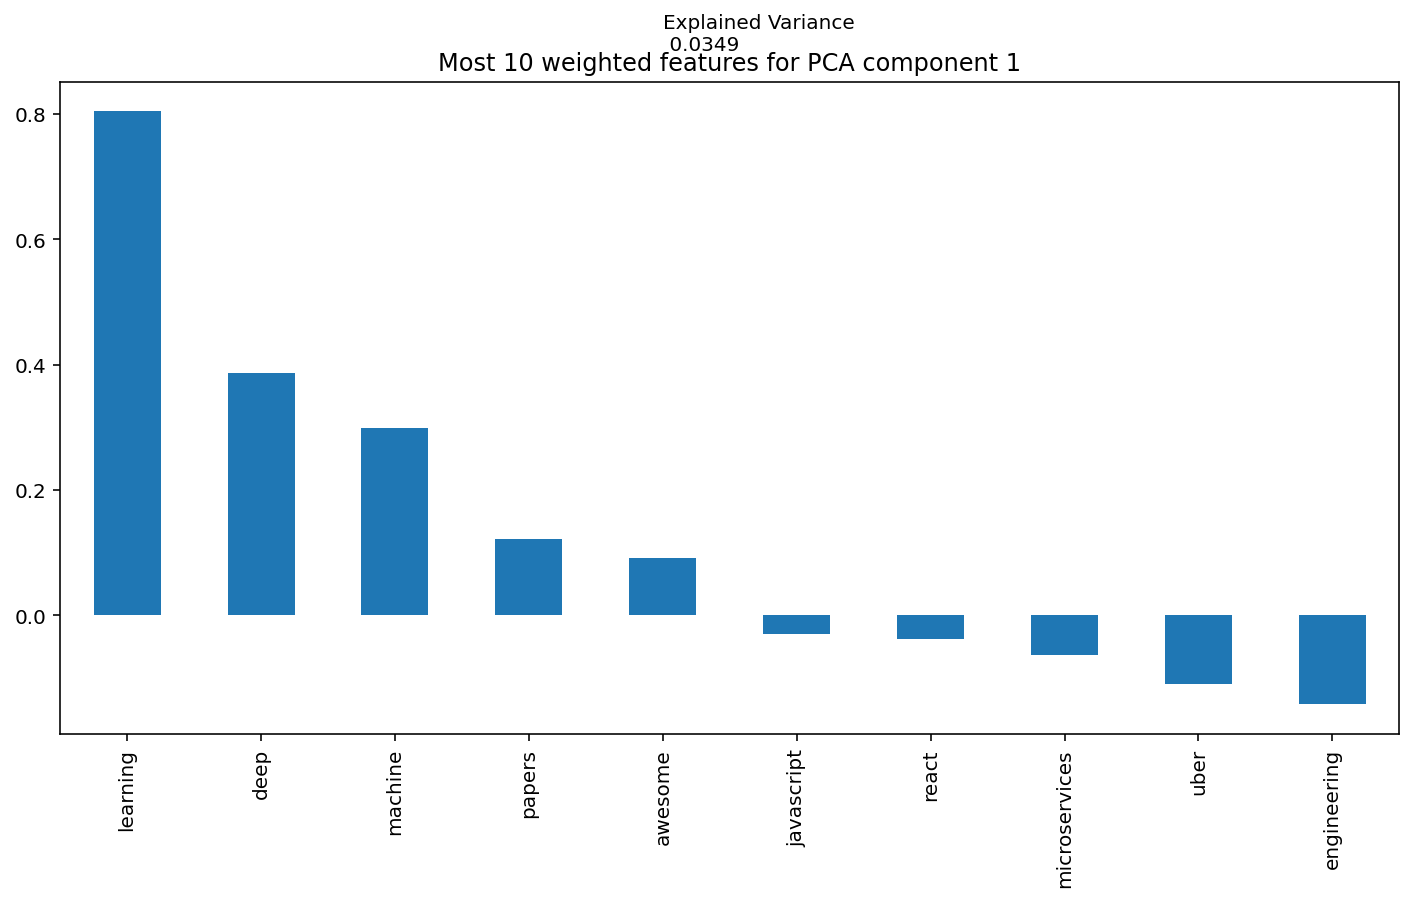

learning         0.8040
deep             0.3861
machine          0.2986
papers           0.1213
awesome          0.0915
javascript      -0.0302
react           -0.0380
microservices   -0.0639
uber            -0.1091
engineering     -0.1425
Name: 0, dtype: float64


In [56]:
# Interpret Principal Components

# # Check first 3 components
# for i in np.arange(0, 3, 1):
#     res = pca_results(azdias_clean_scaled, pca, i, 5)
#     print(res)

res = helper.pca_results(X_eng, pca, 1, 5)
print(res)

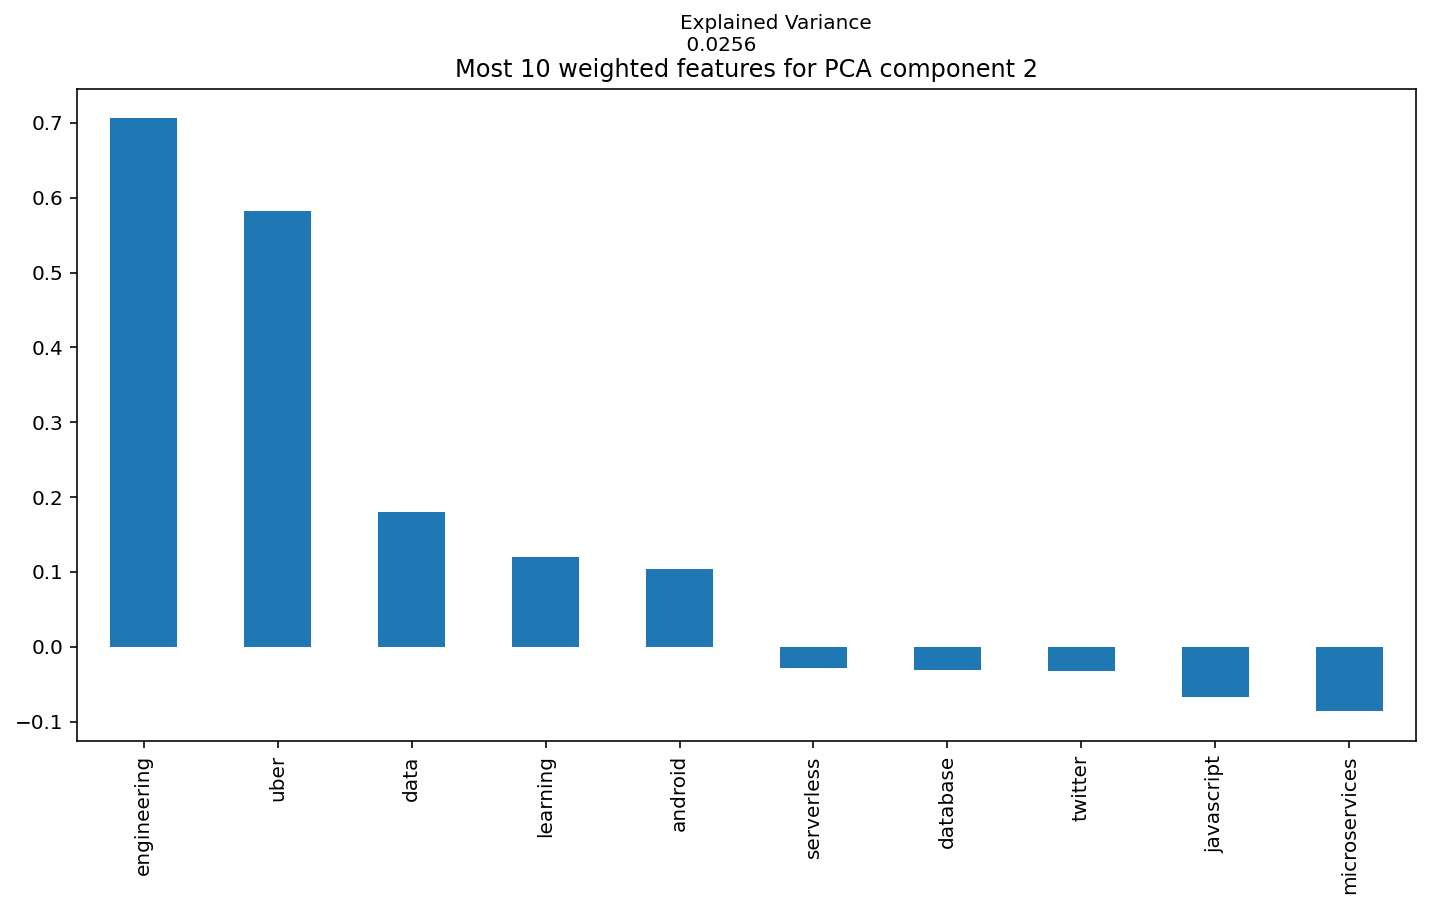

engineering      0.7060
uber             0.5827
data             0.1794
learning         0.1205
android          0.1041
serverless      -0.0278
database        -0.0317
twitter         -0.0327
javascript      -0.0670
microservices   -0.0865
Name: 1, dtype: float64


In [57]:
res = helper.pca_results(X_eng, pca, 2, 5)
print(res)

<br>

https://www.quora.com/What-is-the-most-used-algorithm-for-text-documents-clustering <br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8125674/

## Clustering (Engineering)
- For now, we will use kmeans "the most used clustering algorithm".
- But, we can try other clustering algorithms later.
- If the data is **text-based** the **proximity measure** should be set to **cosine distance**, instead of, euclidian distance.  
- However, this is not the case for kmeans:
- https://stats.stackexchange.com/questions/81481/why-does-k-means-clustering-algorithm-use-only-euclidean-distance-metric

In [58]:
# # Create a toy dataset to reduce computation time
# # Reduce the size to 25%
# X_pca_sample = X_pca[np.random.choice(X_pca.shape[0], int(df.shape[0]*0.25), replace=False)]

In [59]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...   
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
t0 = time()

sse = [] # Sum of Squared Errors
silhouette = []
calinski = []
k_range = np.arange(2, 21)

for k in k_range:
    kmeans = KMeans(k, random_state=42) # , max_iter=30
    model = kmeans.fit(X_eng)
    preds = model.predict(X_eng)
    # Scoring
    sil_score = silhouette_score(X_eng, preds) #, metric='cosine'
    calinski_score = calinski_harabasz_score(X_eng, preds)
    score = np.abs(model.score(X_eng))
    sse.append(score)
    silhouette.append(sil_score)
    calinski.append(calinski_score)
    # Print Results
    print('Clustering done for {} k, with SSE {}'.format(k, round(score, 2)))
    print("For n_clusters = {}, silhouette score is {})".format(k, round(sil_score, 2)))
    print("For n_clusters = {}, calinski_harabasz score is {})".format(k, round(calinski_score, 2)))
    print('-'*50)
    
   
print((time()-t0)/60)

Clustering done for 2 k, with SSE 2592.55
For n_clusters = 2, silhouette score is 0.08)
For n_clusters = 2, calinski_harabasz score is 17.27)
--------------------------------------------------
Clustering done for 3 k, with SSE 2587.23
For n_clusters = 3, silhouette score is 0.03)
For n_clusters = 3, calinski_harabasz score is 9.2)
--------------------------------------------------
Clustering done for 4 k, with SSE 2510.94
For n_clusters = 4, silhouette score is 0.02)
For n_clusters = 4, calinski_harabasz score is 11.8)
--------------------------------------------------
Clustering done for 5 k, with SSE 2501.3
For n_clusters = 5, silhouette score is 0.08)
For n_clusters = 5, calinski_harabasz score is 9.39)
--------------------------------------------------
Clustering done for 6 k, with SSE 2489.16
For n_clusters = 6, silhouette score is 0.03)
For n_clusters = 6, calinski_harabasz score is 8.06)
--------------------------------------------------
Clustering done for 7 k, with SSE 2457.45

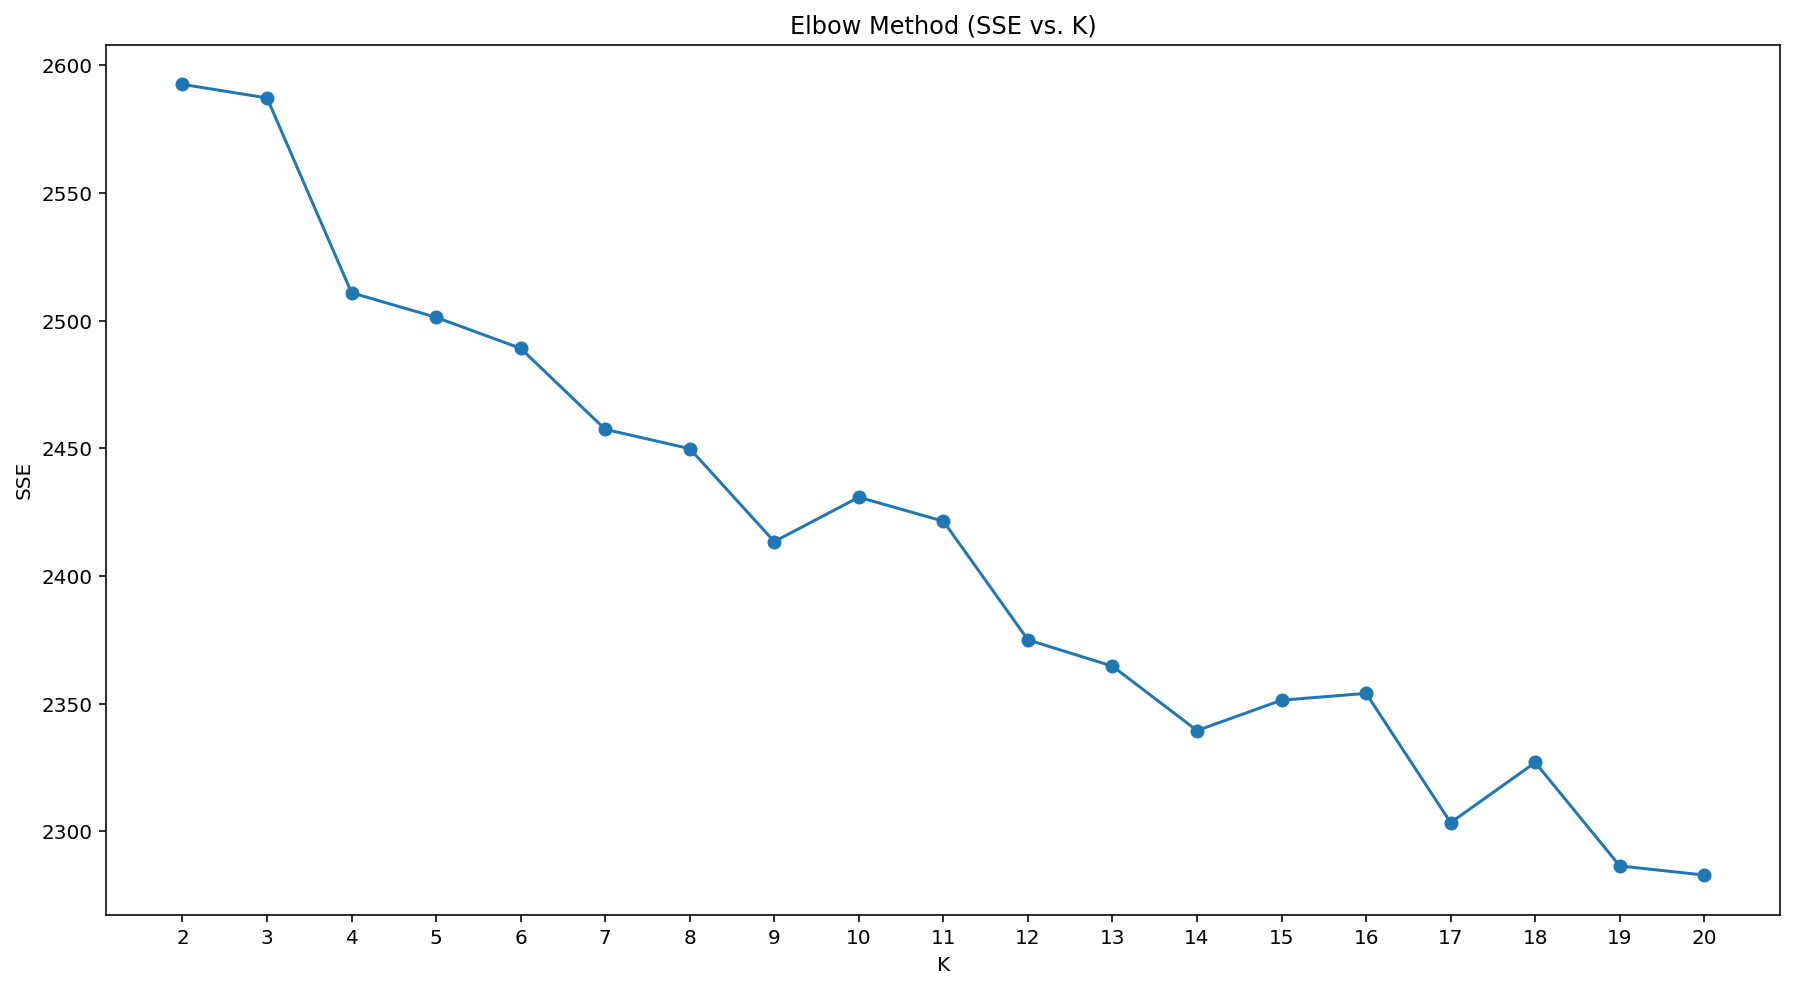

In [60]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Use the Elbow Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method (SSE vs. K)')
plt.plot(k_range, sse, linestyle='-', marker='o');

> **NOTE:**
> - we can not see a clear elbow, but we are going to use 4 clusters as given (prior knowledge),
> - And will validate with Silhouette Score

## Clustering Validation (Engineering)

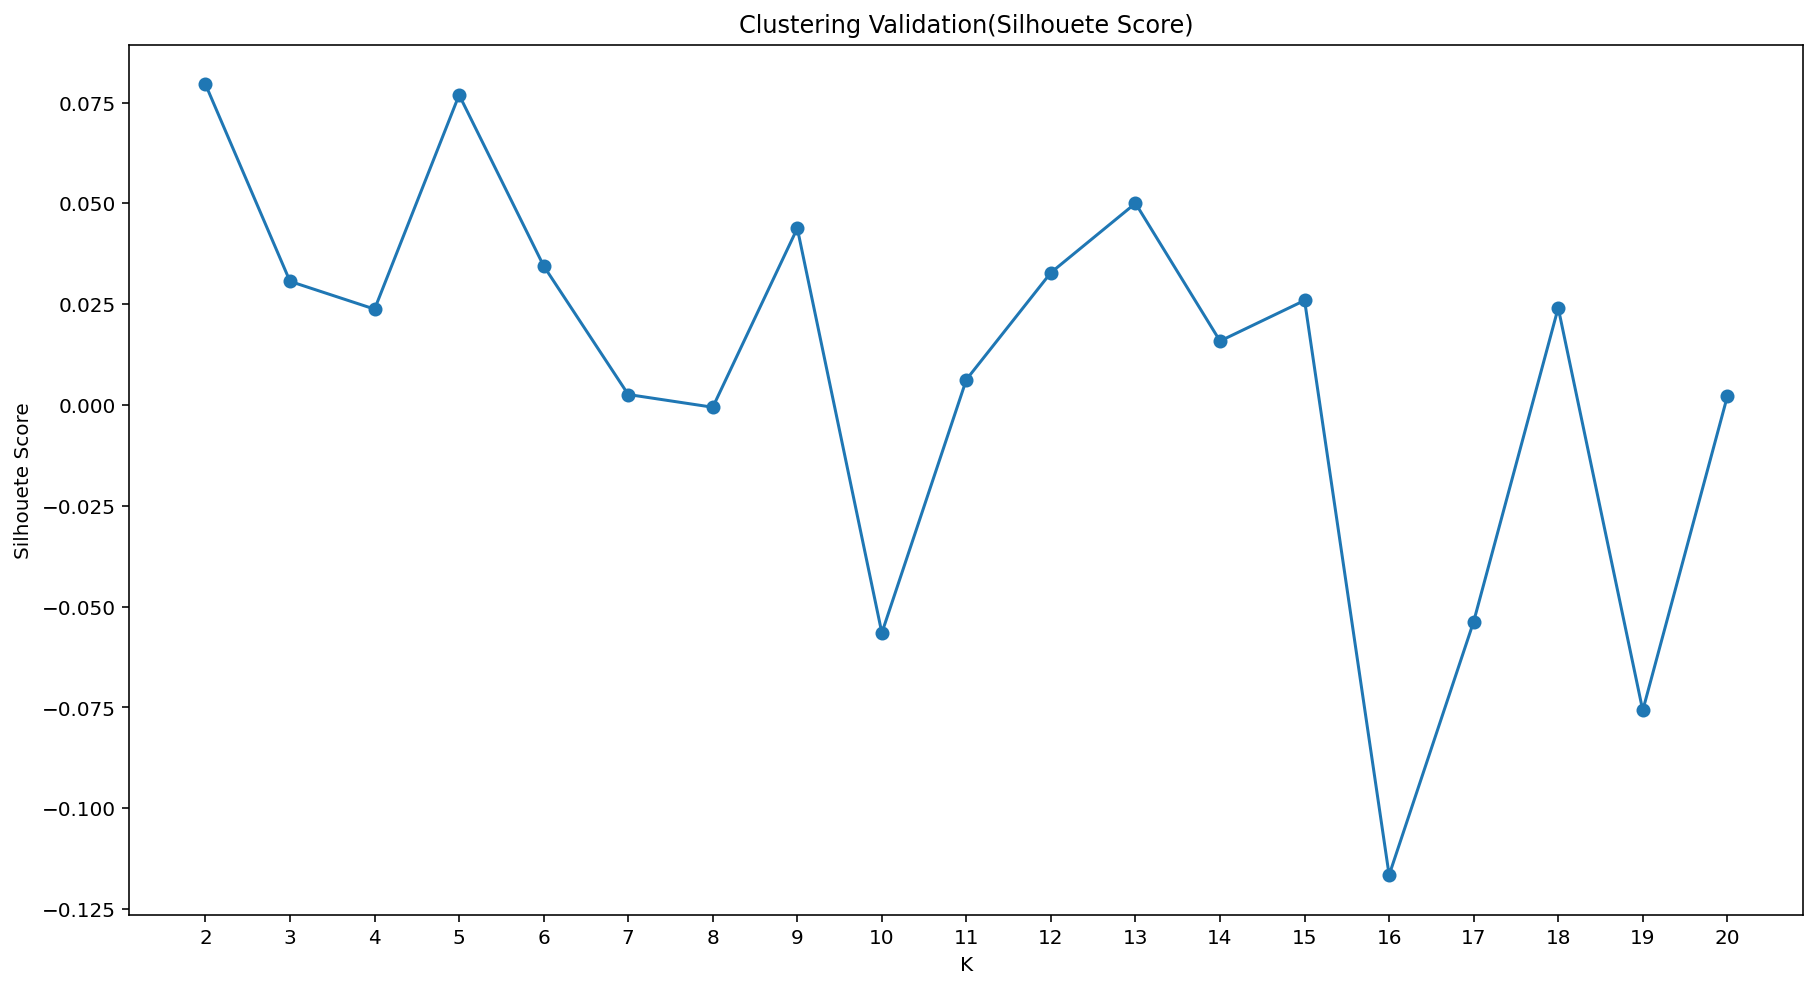

In [61]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('Silhouete Score')
plt.title('Clustering Validation(Silhouete Score)')
plt.plot(k_range, silhouette, linestyle='-', marker='o');

> **NOTE:**
> - Silhouete Score suggests k=5, but we are going to use 4 clusters as given (prior knowledge).

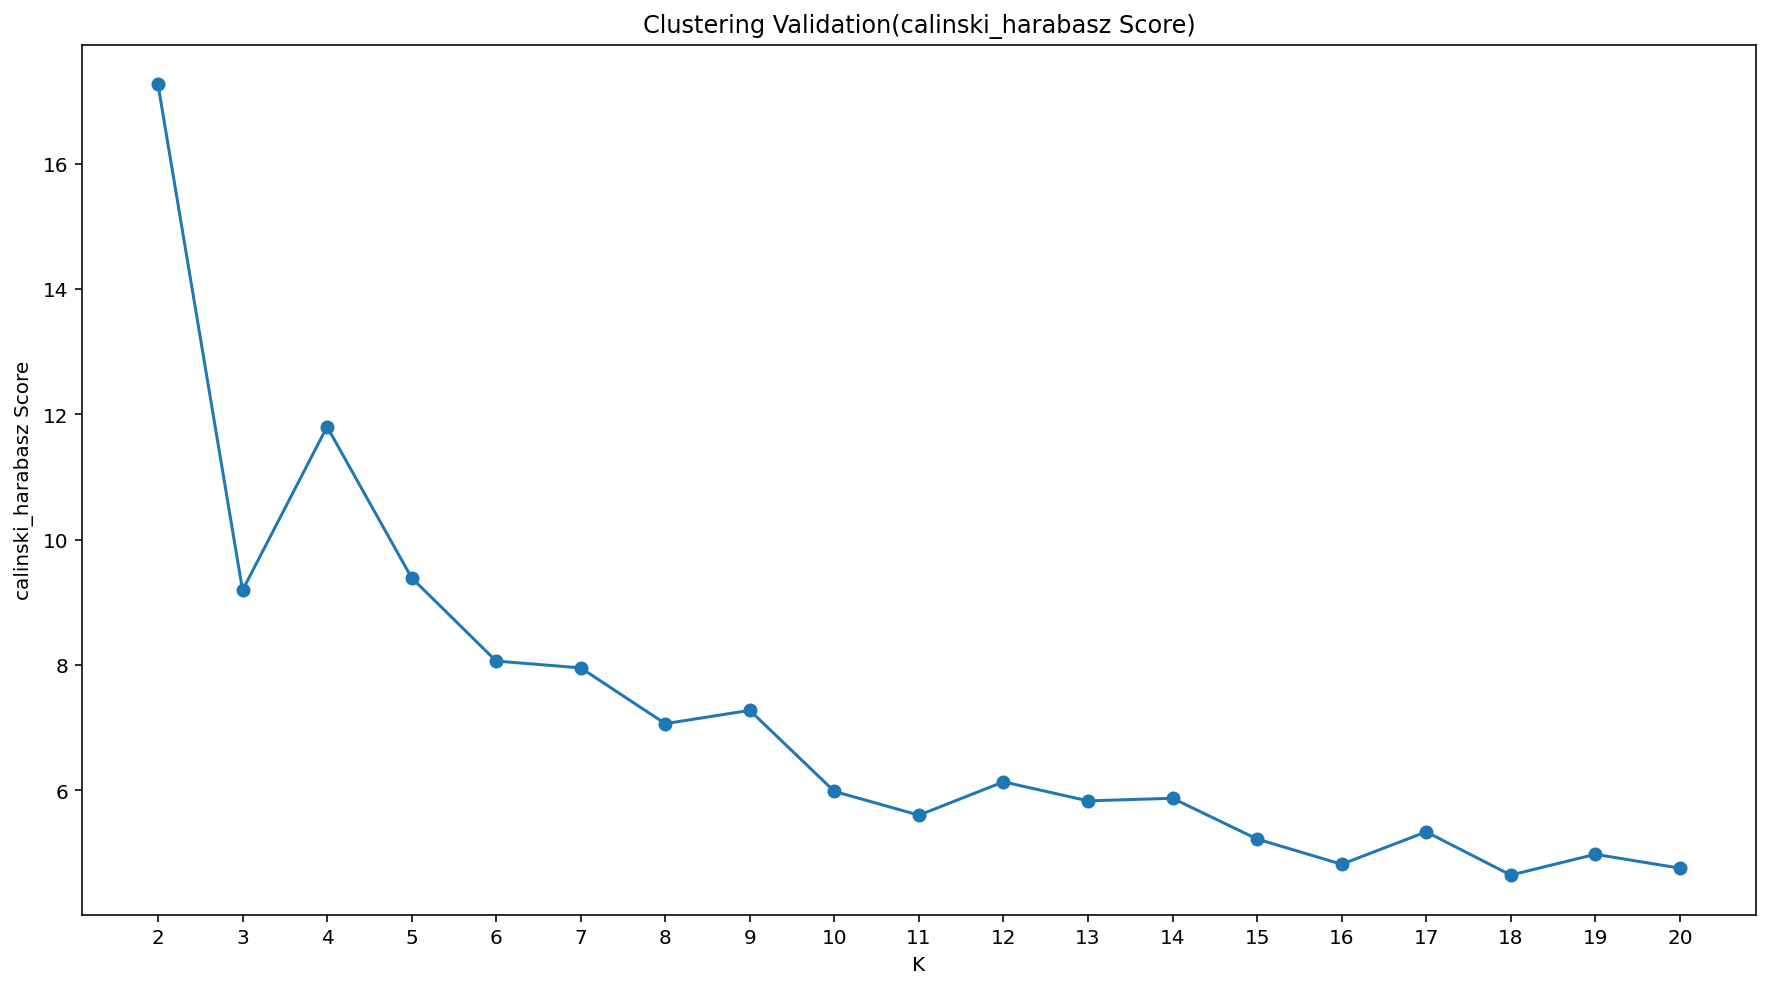

In [62]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('calinski_harabasz Score')
plt.title('Clustering Validation(calinski_harabasz Score)')
plt.plot(k_range, calinski, linestyle='-', marker='o');

In [63]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
t0 = time()

kmeans_4 = KMeans(n_clusters=4, random_state=42)
model_eng = kmeans_4.fit(X_eng)
clusters_eng = model_eng.predict(X_eng)

print(time()-t0)

0.2490520477294922


In [64]:
clusters_eng 

array([1, 3, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       0, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 3,
       1, 1, 1, 2, 0, 2, 3, 1, 0, 0, 0, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 3,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1,
       1, 1, 3, 1, 1, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 3, 2, 2,
       1, 0, 0, 1, 1, 1, 3, 1, 1, 1, 0, 1, 3, 3, 3,

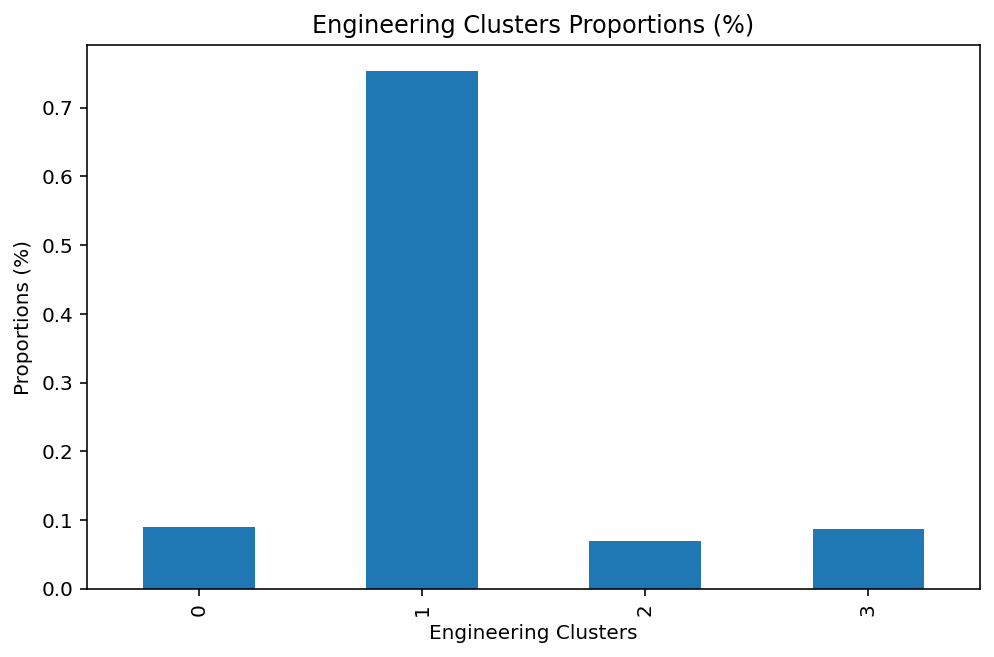

In [65]:
# Compare the proportion of data in each cluster 

# _c --> count
clusters_eng_c = pd.Series(clusters_eng).value_counts().sort_index()

# Calculate proprotions
prop_eng = clusters_eng_c / clusters_eng_c.sum()

# PLOT
plt.figure(figsize=(8, 5))
prop_eng.plot.bar(); # .sort_values(ascending=False)
plt.title('Engineering Clusters Proportions (%)')
plt.xlabel('Engineering Clusters');
plt.ylabel('Proportions (%)');

> **NOTE:**
> - The majority of the engineering articles falls into cluster (0)

**Get the most important features(words) for cluster (0)**

In [66]:
centroid_eng_0 = pd.Series(model_eng.cluster_centers_[0]).sort_values(ascending=False)
centroid_eng_0.head(10)

1669    1.142857
1749    0.469388
706     0.448980
670     0.122449
3194    0.102041
2112    0.081633
195     0.061224
1988    0.061224
1967    0.040816
3239    0.040816
dtype: float64

In [67]:
li = [3,5, 9]
print(np.r_[(*li,)])
np.r_[tuple(li)]

[3 5 9]


array([3, 5, 9])

In [68]:
# Got an index error --> because we should locate columns and not rows
print(X_eng.shape)
X.iloc[0, np.r_[tuple(centroid_eng_0.head(10).index)]].index.to_list()

(547, 3358)


['learning',
 'machine',
 'deep',
 'data',
 'using',
 'papers',
 'awesome',
 'neural',
 'nanonets',
 'visual']

> **NOTE:**
> - cluster (0) --> mapped into **Machine Learning**

<br>

**Get the most important features(words) for cluster (1)**

In [69]:
centroid_eng_1 = pd.Series(model_eng.cluster_centers_[1]).sort_values(ascending=False)
centroid_eng_1.head(10)

953     0.080097
3137    0.070388
2406    0.053398
1567    0.050971
330     0.046117
3194    0.033981
2156    0.031553
671     0.031553
3130    0.031553
1985    0.029126
dtype: float64

In [142]:
# Got an index error --> because we should locate columns and not rows
print(X_eng.shape)
X.iloc[0, np.r_[tuple(centroid_eng_1.head(10).index)]].index.to_list()

(547, 3358)


['engineering',
 'uber',
 'react',
 'javascript',
 'building',
 'using',
 'performance',
 'database',
 'twitter',
 'netflix']

> **NOTE:**
> - cluster (1) --> mapped into ****

<br>

**Get the most important features(words) for cluster (2)**

In [71]:
centroid_eng_2 = pd.Series(model_eng.cluster_centers_[2]).sort_values(ascending=False)
centroid_eng_2.head(10)

670     1.078947
953     0.157895
2626    0.157895
74      0.157895
2616    0.078947
3319    0.078947
1074    0.052632
1286    0.052632
404     0.052632
2294    0.052632
dtype: float64

In [141]:
# Got an index error --> because we should locate columns and not rows
print(X_eng.shape)
print(X.iloc[0, np.r_[tuple(centroid_eng_2.head(1).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_eng_2.iloc[1:10].index)]].index.to_list()

(547, 3358)
['data']


['engineering',
 'science',
 'airbnb',
 'scaling',
 'world',
 'fast',
 'growth',
 'changing',
 'processing']

> **NOTE:**
> - cluster (2) --> mapped into ****

<br>

**Get the most important features(words) for cluster (3)**

In [73]:
centroid_eng_3 = pd.Series(model_eng.cluster_centers_[3]).sort_values(ascending=False)
centroid_eng_3.head(10)

1861    0.708333
137     0.416667
2416    0.104167
1860    0.083333
953     0.062500
1985    0.062500
69      0.041667
272     0.041667
136     0.041667
2570    0.041667
dtype: float64

In [74]:
# Get an index error --> because we should locate columns and not rows
print(X_eng.shape)
# X.iloc[0, np.r_[tuple(centroid_eng_3.head(10).index)]].index.to_list()

print(X.iloc[0, np.r_[tuple(centroid_eng_3.head(1).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_eng_3.iloc[1:10].index)]].index.to_list()

(547, 3358)
['microservices']


['architecture',
 'real',
 'microservice',
 'engineering',
 'netflix',
 'agile',
 'blog',
 'architectural',
 'running']

> **NOTE:**
> - cluster (2) --> mapped into ****

## Save Engineering Clusters

In [150]:
engineering_clusters = df[['body', 'title', 'category']].query(" category == 'Engineering' ")
engineering_clusters['sub_category'] = clusters_eng
engineering_clusters['sub_category'] = engineering_clusters.sub_category.map({0: 'eng_1', 1: 'eng_2', 2: 'eng_3', 3: 'eng_4'})
print(engineering_clusters.shape)
print(f'Value Counts:\n{engineering_clusters.sub_category.value_counts()}')
engineering_clusters.head(1)

(547, 4)
Value Counts:
eng_2    412
eng_1     49
eng_4     48
eng_3     38
Name: sub_category, dtype: int64


,body,title,category,sub_category
1,JAXenter: Have microservices helped you achiev...,"""The size of a microservice is the size of the...",Engineering,eng_2


In [151]:
engineering_clusters.to_json('Clustered_Subcategories/engineering_clusters.json')

<br>

<a id='product'></a> 
### Feature Extraction (Product & Design)
<ul>
<li><a href="#eng">Engineering</a></li>
<li><a href="#product"><b>Product & Design</b></a></li>
<li><a href="#business">Startups & Business</a></li>
</ul>

In [75]:
df_prod = X_to_filter.query(" article_category == 'Product & Design'")
X_prod = df_prod.iloc[:, 1:]
print(X_prod.shape)
X_prod.head(1)

(846, 3358)


,aarron,able,abstraction,abstractions,abstractive,abundance,abuse,academia,accelerate,accelerates,...,zara,zdnet,zero,zhuo,zillow,zola,zombie,zones,zuckerberg,zuul
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
# # Apply feature scaling to the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_prod_scaled = scaler.fit_transform(X_product) #Mean=0, Std=1

# X_prod_scaled = pd.DataFrame(data_prod_scaled, columns=list(X_engineering.columns))
# print(X_prod_scaled.shape)
# X_prod_scaled.head(1)

In [77]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
X_prod_pca = pca.fit_transform(X_prod)

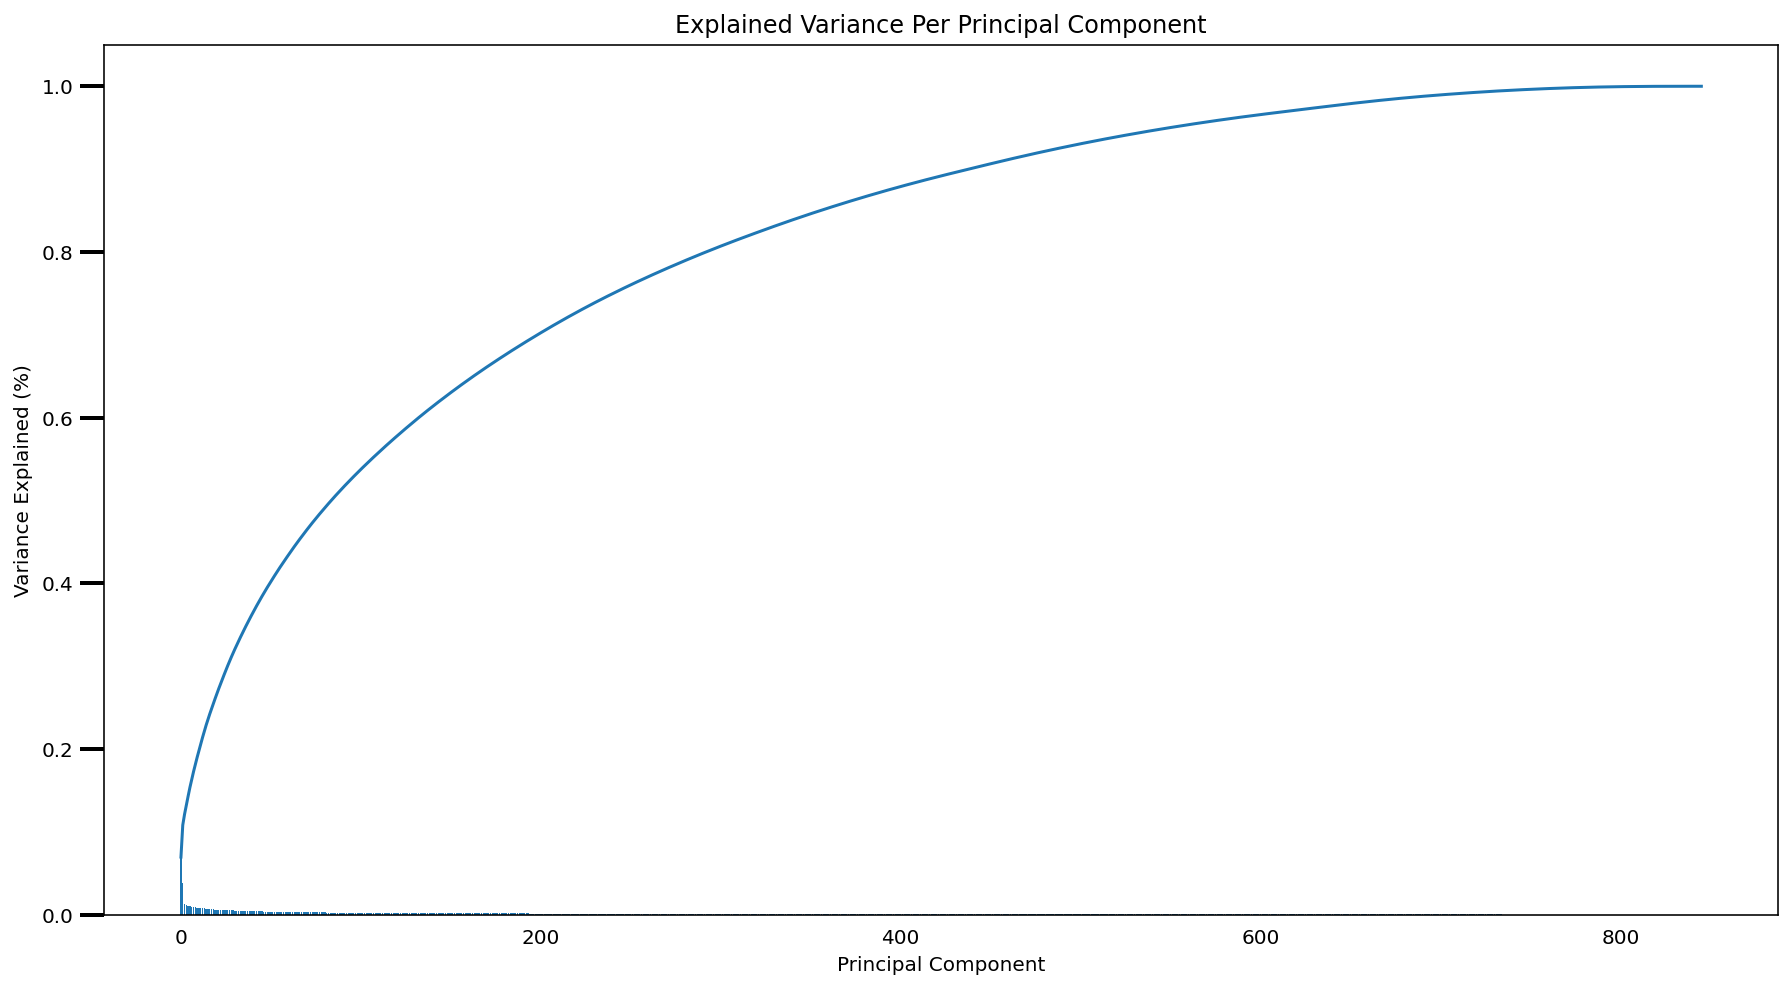

In [78]:
# To get the number of pca components to use (highest variance)
helper.scree_plot(pca)

In [79]:
# Re-apply PCA to the data while selecting for number of components to retain.

num_components=len(pca.explained_variance_ratio_)
vals = pca.explained_variance_ratio_

cumvals = np.cumsum(vals)
ind = next(x[0] for x in enumerate(cumvals) if x[1] > 0.8)
num_comps = ind+1
num_comps

print(f'{num_comps} PCA components --> allow us to capture {round(cumvals[num_comps-1]*100,2)}% of data variability')

293 PCA components --> allow us to capture 80.01% of data variability


In [80]:
pca = PCA(n_components=num_comps)
X_prod_pca = pca.fit_transform(X_eng)

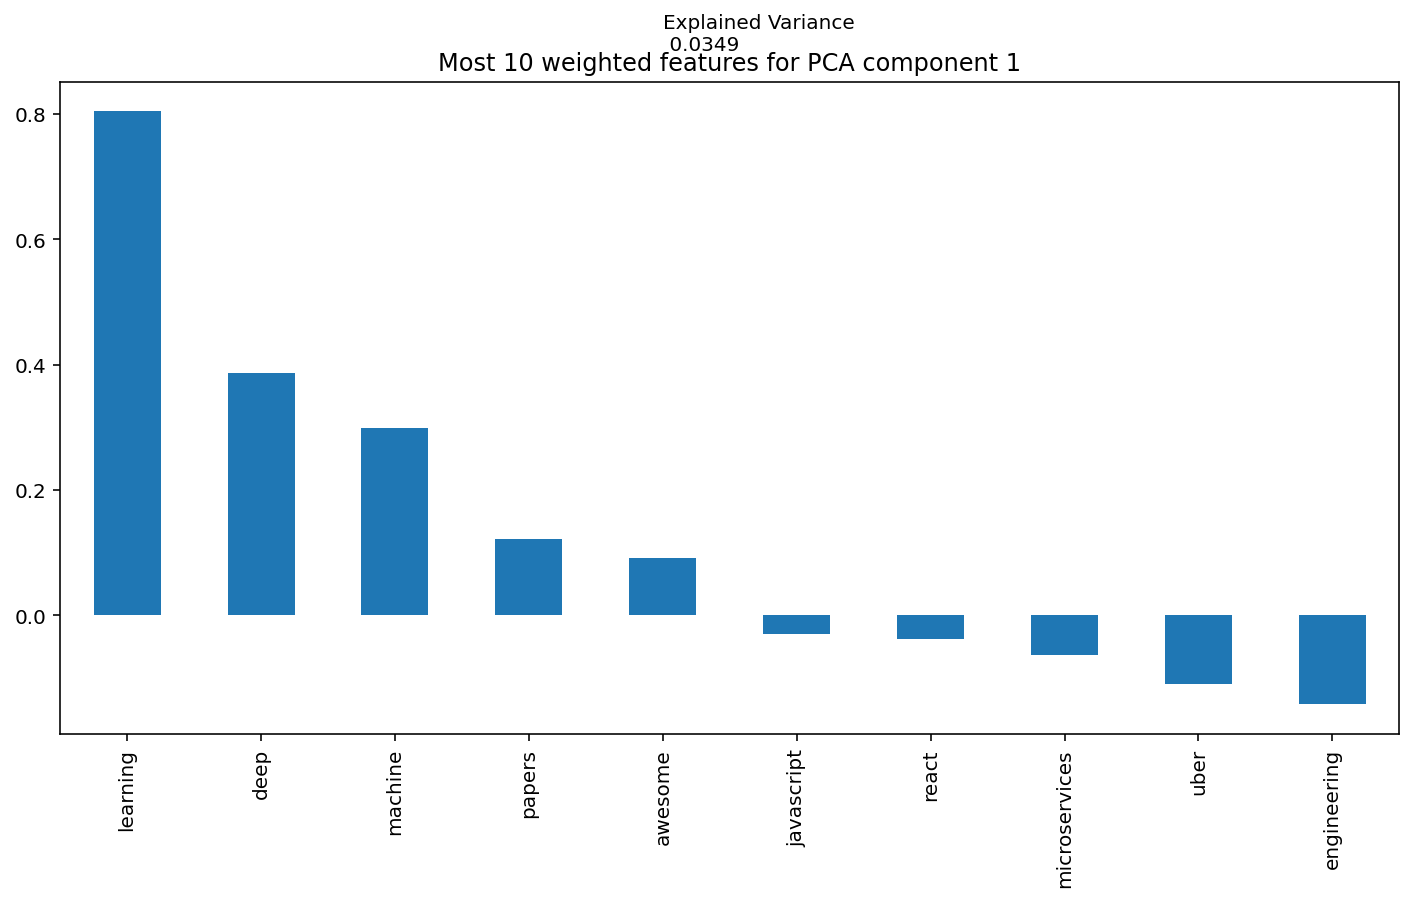

learning         0.8040
deep             0.3861
machine          0.2986
papers           0.1213
awesome          0.0915
javascript      -0.0302
react           -0.0380
microservices   -0.0639
uber            -0.1091
engineering     -0.1425
Name: 0, dtype: float64


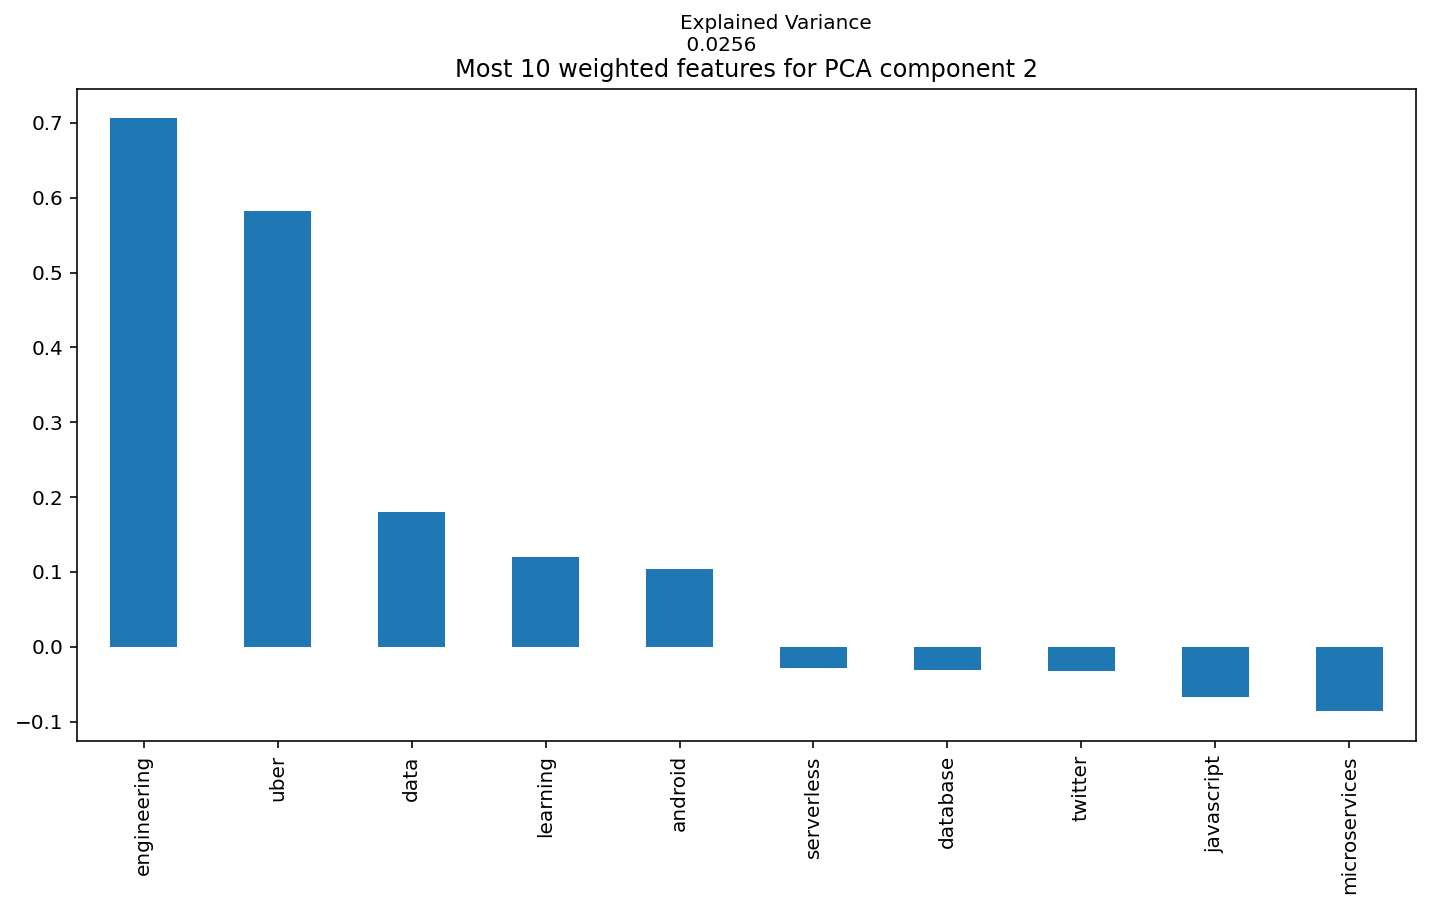

engineering      0.7060
uber             0.5827
data             0.1794
learning         0.1205
android          0.1041
serverless      -0.0278
database        -0.0317
twitter         -0.0327
javascript      -0.0670
microservices   -0.0865
Name: 1, dtype: float64


In [81]:
# Interpret Principal Components

res = helper.pca_results(X_prod, pca, 1, 5)
print(res)

res = helper.pca_results(X_prod, pca, 2, 5)
print(res)

<br>

## Clustering (Product & Design)

In [82]:
# # Create a toy dataset to reduce computation time
# # Reduce the size to 25%
# X_pca_sample = X_pca[np.random.choice(X_pca.shape[0], int(df.shape[0]*0.25), replace=False)]

In [83]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...   
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
t0 = time()

sse = [] # Sum of Squared Errors
silhouette = []
calinski = []
k_range = np.arange(2, 21)

for k in k_range:
    kmeans = KMeans(k, random_state=42) # , max_iter=30
    model = kmeans.fit(X_prod)
    preds = model.predict(X_prod)
    # Scoring
    sil_score = silhouette_score(X_prod, preds) #, metric='cosine'
    calinski_score = calinski_harabasz_score(X_prod, preds)
    score = np.abs(model.score(X_prod))
    sse.append(score)
    silhouette.append(sil_score)
    calinski.append(calinski_score)
    # Print Results
    print('Clustering done for {} k, with SSE {}'.format(k, round(score, 2)))
    print("For n_clusters = {}, silhouette score is {})".format(k, round(sil_score, 2)))
    print("For n_clusters = {}, calinski_harabasz score is {})".format(k, round(calinski_score, 2)))
    print('-'*50)
    
   
print((time()-t0)/60)

Clustering done for 2 k, with SSE 3529.06
For n_clusters = 2, silhouette score is 0.06)
For n_clusters = 2, calinski_harabasz score is 56.22)
--------------------------------------------------
Clustering done for 3 k, with SSE 3406.08
For n_clusters = 3, silhouette score is 0.06)
For n_clusters = 3, calinski_harabasz score is 44.31)
--------------------------------------------------
Clustering done for 4 k, with SSE 3383.49
For n_clusters = 4, silhouette score is 0.06)
For n_clusters = 4, calinski_harabasz score is 31.58)
--------------------------------------------------
Clustering done for 5 k, with SSE 3357.14
For n_clusters = 5, silhouette score is 0.04)
For n_clusters = 5, calinski_harabasz score is 25.49)
--------------------------------------------------
Clustering done for 6 k, with SSE 3340.01
For n_clusters = 6, silhouette score is 0.03)
For n_clusters = 6, calinski_harabasz score is 21.33)
--------------------------------------------------
Clustering done for 7 k, with SSE 3

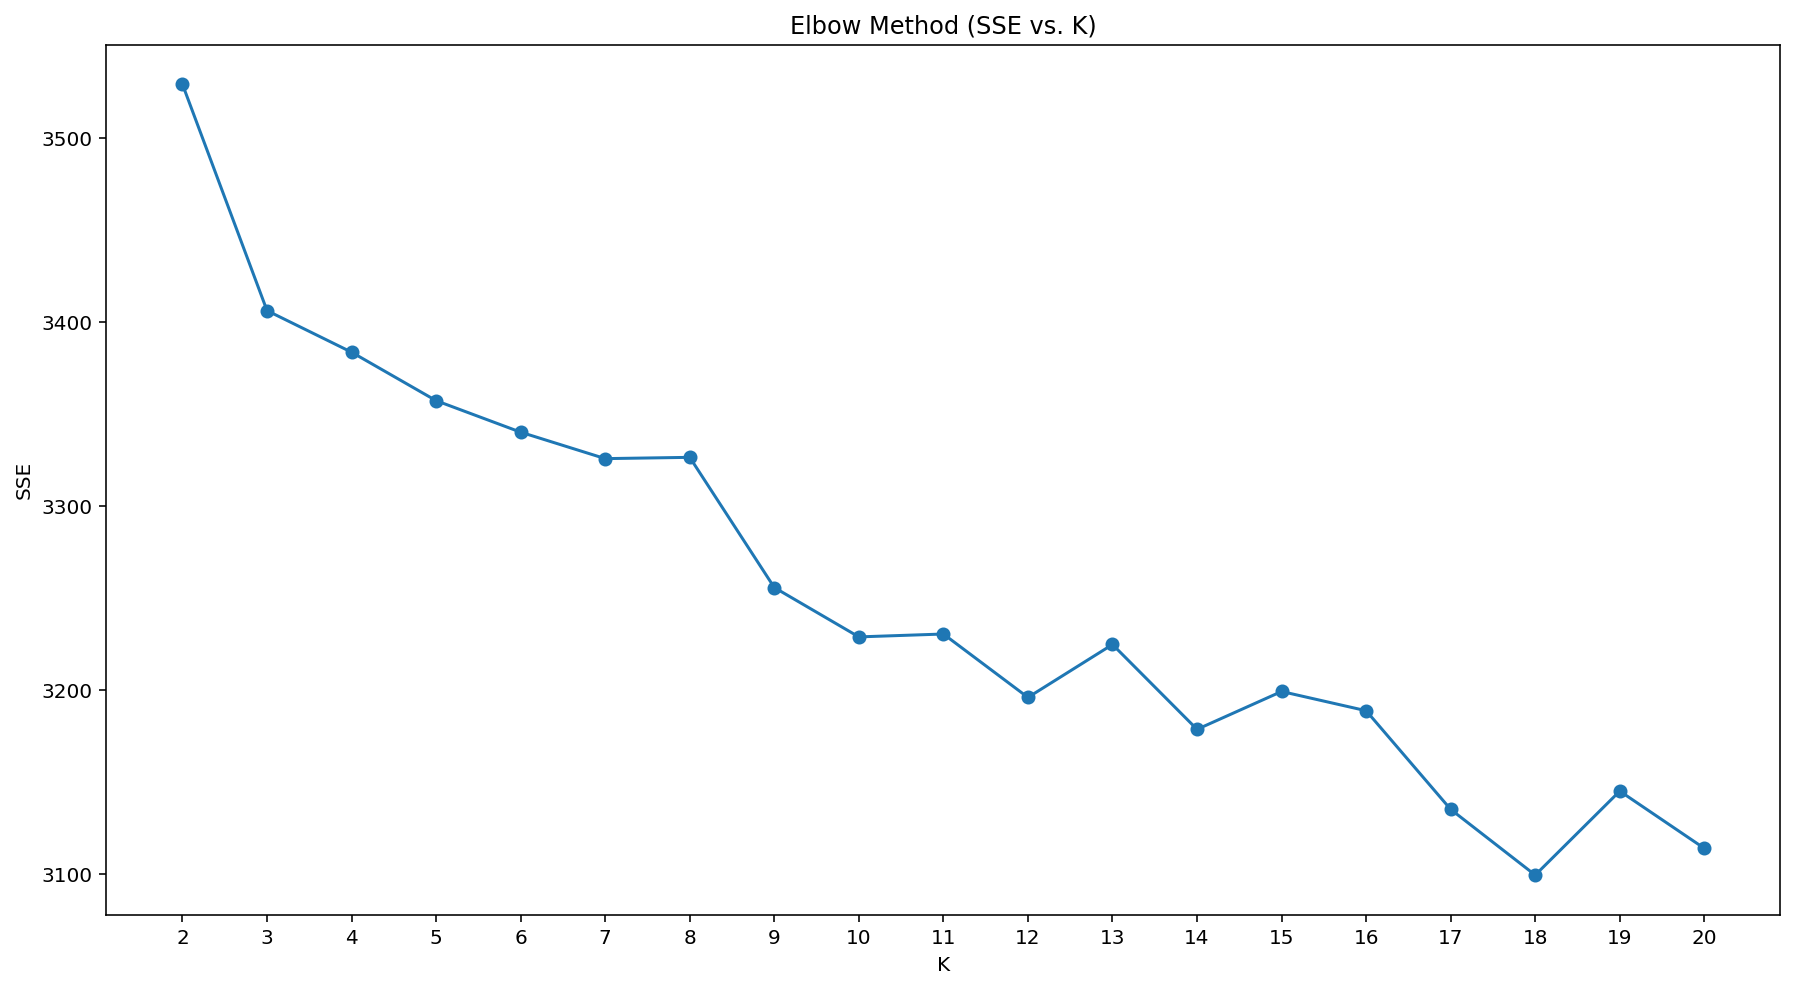

In [84]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Use the Elbow Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method (SSE vs. K)')
plt.plot(k_range, sse, linestyle='-', marker='o');

## Clustering Validation (Product & Design)

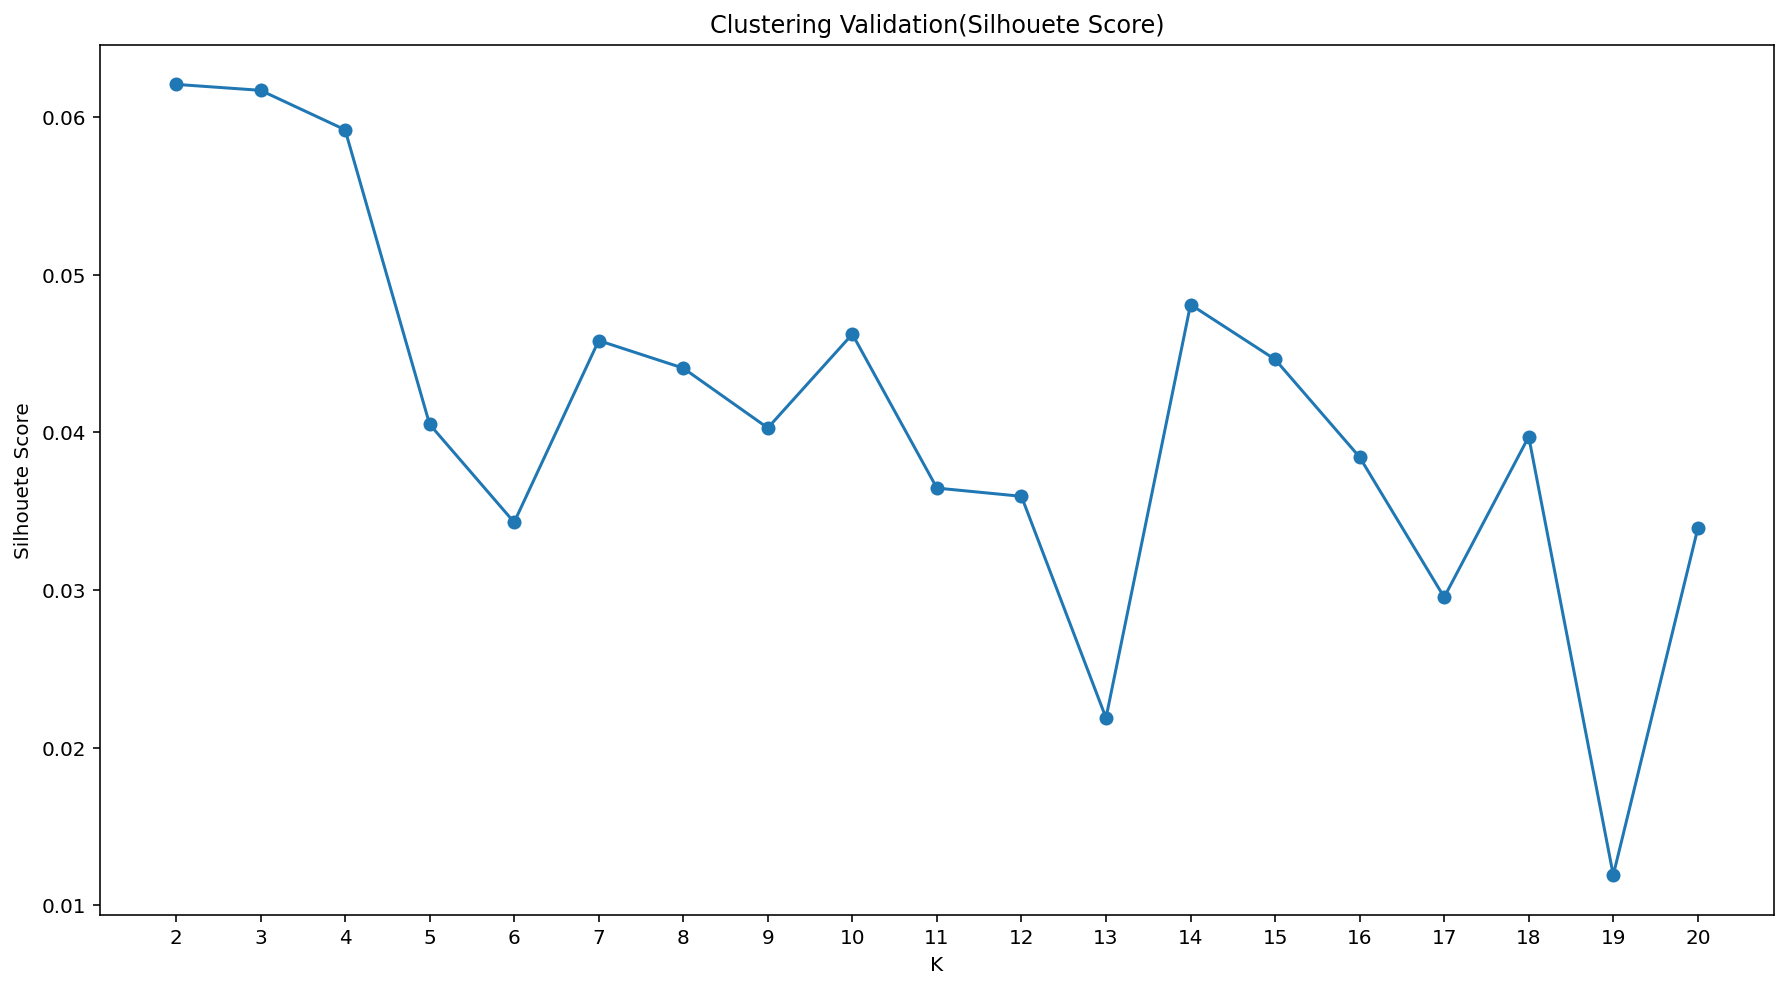

In [85]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('Silhouete Score')
plt.title('Clustering Validation(Silhouete Score)')
plt.plot(k_range, silhouette, linestyle='-', marker='o');

> **NOTE:**
> - Silhouete Score suggests k=4.

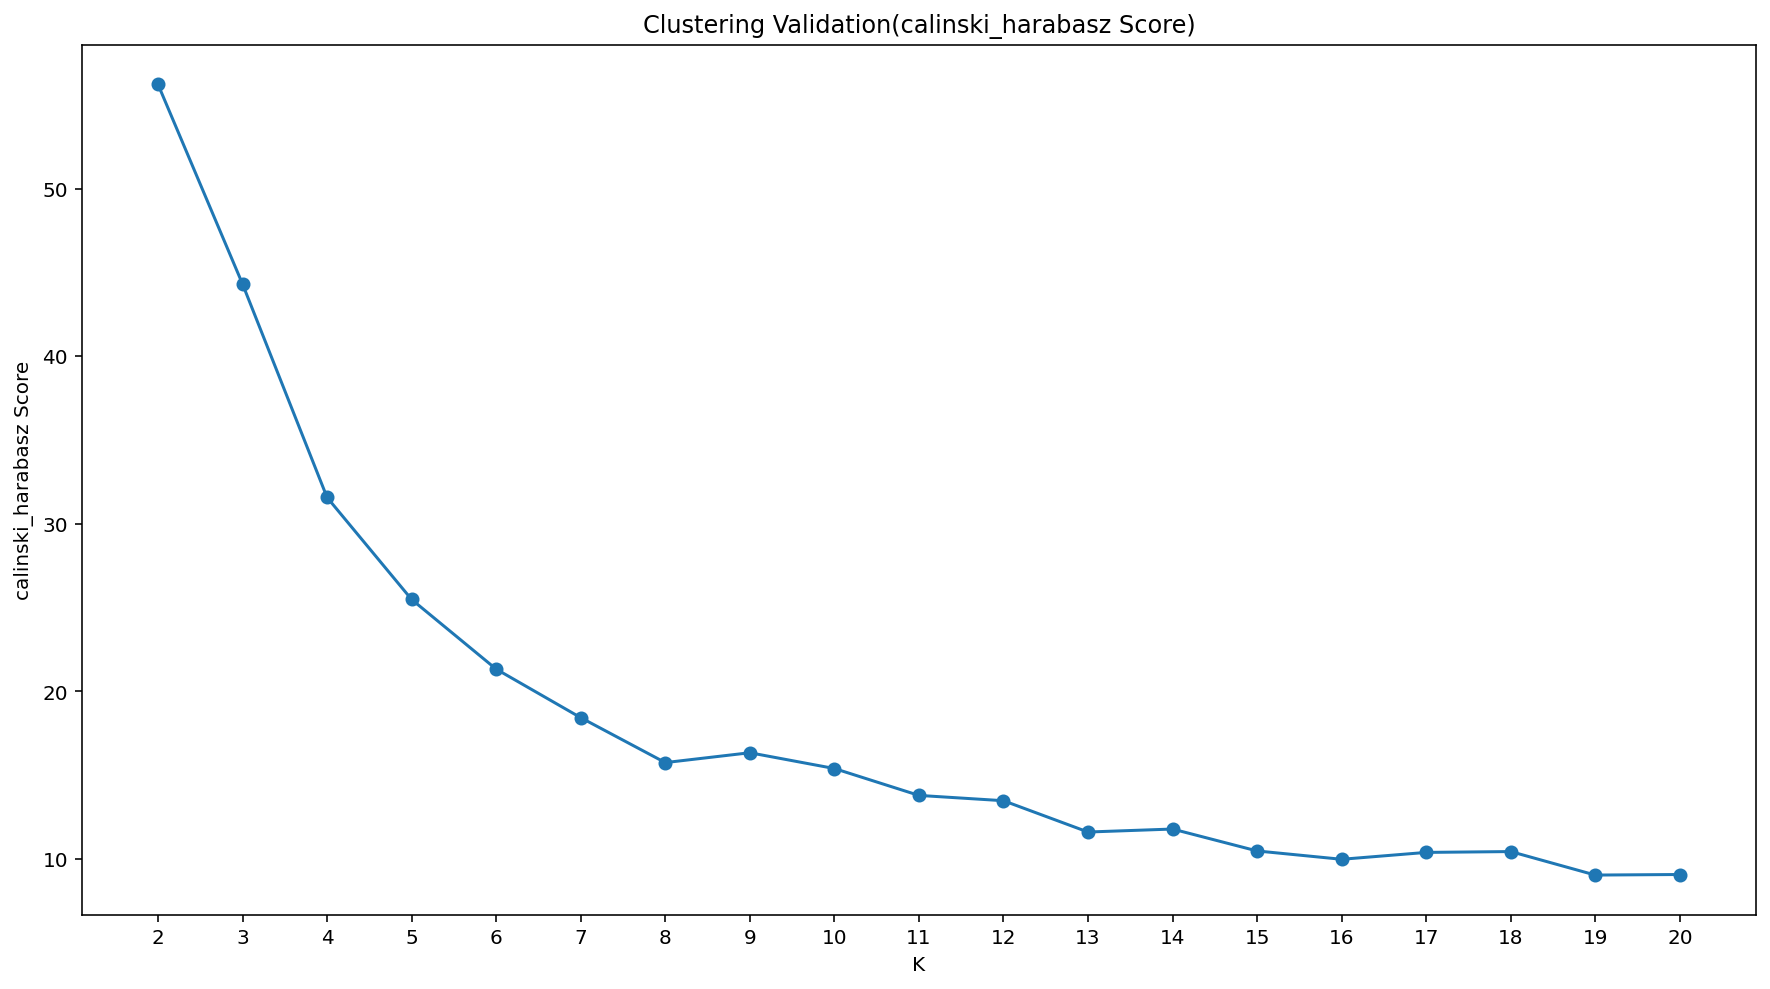

In [86]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('calinski_harabasz Score')
plt.title('Clustering Validation(calinski_harabasz Score)')
plt.plot(k_range, calinski, linestyle='-', marker='o');

In [87]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
t0 = time()

kmeans_4 = KMeans(n_clusters=4, random_state=42)
model_prod = kmeans_4.fit(X_prod)
clusters_prod = model_prod.predict(X_prod)

print(time()-t0)

0.3255000114440918


In [88]:
clusters_prod 

array([2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 3, 3, 2,
       1, 2, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 2, 1, 0, 1, 2, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 2, 2, 1, 1,
       1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 1, 0, 2, 2, 1,
       2, 2, 2, 2, 2, 1, 0, 1, 1, 1, 0, 2, 2, 1, 0, 2, 2, 1, 1, 1, 2, 1,
       1, 2, 1, 1, 2, 2, 1, 3, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2,
       0, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 1, 1, 2, 2, 1, 2, 2, 1, 2,
       2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 1, 0, 2, 2, 1, 2, 1, 2, 1, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 1, 0, 2, 1, 1, 2, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2,
       0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 3,

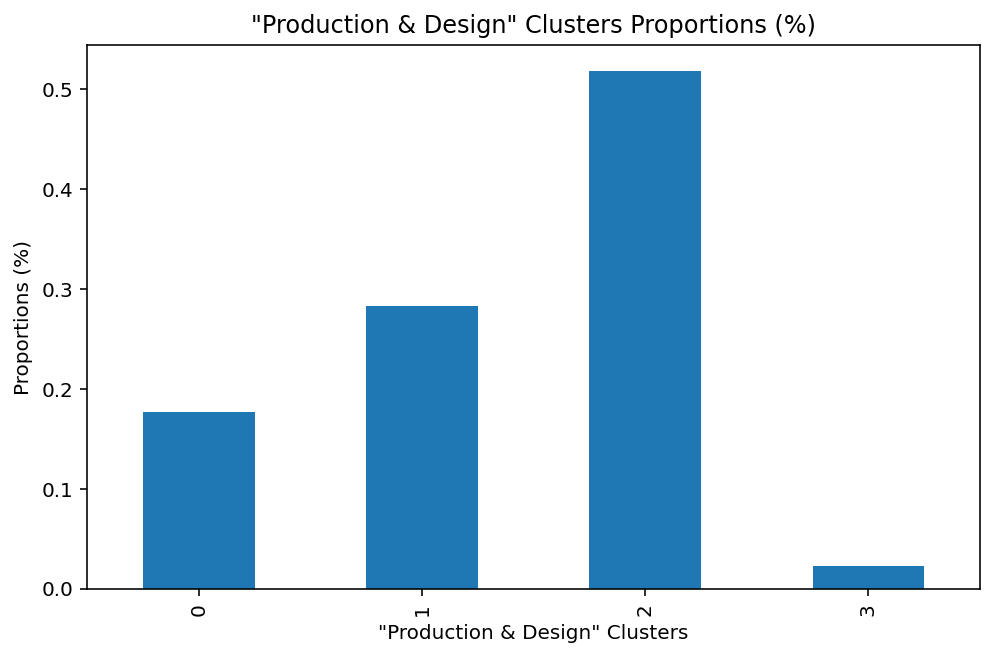

In [89]:
# Compare the proportion of data in each cluster 

# _c --> count
clusters_prod_c = pd.Series(clusters_prod).value_counts().sort_index()

# Calculate proprotions
prop_prod = clusters_prod_c / clusters_prod_c.sum()

# PLOT
plt.figure(figsize=(8, 5))
prop_prod.plot.bar(); # .sort_values(ascending=False)
plt.title('"Production & Design" Clusters Proportions (%)')
plt.xlabel('"Production & Design" Clusters');
plt.ylabel('Proportions (%)');

> **NOTE:**
> - The majority of the Product & Design articles falls into cluster (0).

**Get the most important features(words) for cluster (0)**

In [90]:
centroid_prod_0 = pd.Series(model_prod.cluster_centers_[0]).sort_values(ascending=False)
centroid_prod_0.head(10)

749     1.066667
2296    0.160000
3020    0.053333
2975    0.046667
2818    0.046667
1294    0.046667
2277    0.040000
2819    0.033333
1048    0.033333
670     0.033333
dtype: float64

In [91]:
# Got an index error --> because we should locate columns and not rows
print(X_prod.shape)
X.iloc[0, np.r_[tuple(centroid_prod_0.head(10).index)]].index.to_list()

(846, 3358)


['design',
 'product',
 'thinking',
 'team',
 'sprint',
 'guide',
 'principles',
 'sprints',
 'facebook',
 'data']

> **NOTE:**
> - cluster (0) --> mapped into **product design**

<br>

**Get the most important features(words) for cluster (1)**

In [92]:
centroid_prod_1 = pd.Series(model_prod.cluster_centers_[1]).sort_values(ascending=False)
centroid_prod_1.head(10)

2296    1.000000
1767    0.171548
1768    0.121339
1769    0.100418
767     0.058577
2292    0.050209
2976    0.050209
246     0.037657
1294    0.037657
3264    0.033473
dtype: float64

In [93]:
# Got an index error --> because we should locate columns and not rows
print(X_prod.shape)
print(X.iloc[0, np.r_[tuple(centroid_prod_1.head(3).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_prod_1.iloc[3:10].index)]].index.to_list()

(846, 3358)
['product', 'management', 'manager']


['managers', 'development', 'process', 'teams', 'best', 'guide', 'ways']

> **NOTE:**
> - cluster (1) --> mapped into **product manager guide**

<br>

**Get the most important features(words) for cluster (2)**

In [94]:
centroid_prod_2 = pd.Series(model_prod.cluster_centers_[2]).sort_values(ascending=False)
centroid_prod_2.head(10)

753     0.066210
3191    0.061644
2301    0.057078
655     0.054795
3192    0.045662
752     0.043379
2499    0.034247
2041    0.034247
247     0.034247
330     0.029680
dtype: float64

In [95]:
# Got an index error --> because we should locate columns and not rows
print(X_prod.shape)
print(X.iloc[0, np.r_[tuple(centroid_prod_2.head(3).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_prod_2.iloc[3:10].index)]].index.to_list()

(846, 3358)
['designing', 'user', 'products']


['customer',
 'users',
 'designers',
 'research',
 'onboarding',
 'better',
 'building']

> **NOTE:**
> - cluster (2) --> mapped into **management best practices**

<br>

**Get the most important features(words) for cluster (3)**

In [96]:
centroid_prod_3 = pd.Series(model_prod.cluster_centers_[3]).sort_values(ascending=False)
centroid_prod_3.head(10)

2296    2.000000
1768    0.315789
1769    0.315789
1767    0.157895
1819    0.105263
2102    0.105263
696     0.105263
247     0.105263
1294    0.105263
767     0.105263
dtype: float64

In [97]:
# Get an index error --> because we should locate columns and not rows
print(X_prod.shape)
X.iloc[0, np.r_[tuple(centroid_prod_3.head(10).index)]].index.to_list()

(846, 3358)


['product',
 'manager',
 'managers',
 'management',
 'meeting',
 'owner',
 'decisions',
 'better',
 'guide',
 'development']

> **NOTE:**
> - cluster (2) --> mapped into **data-driven decisions**

## Save Product & Design Clusters

In [154]:
product_clusters = df[['body', 'title', 'category']].query(" category == 'Product & Design' ")
product_clusters['sub_category'] = clusters_prod
product_clusters['sub_category'] = product_clusters.sub_category.map({0: 'prod_1', 1: 'prod_2', 2: 'prod_3', 3: 'prod_4'})
print(product_clusters.shape)
print(f'Value Counts:\n{product_clusters.sub_category.value_counts()}')
product_clusters.head(1)

(846, 4)
Value Counts:
prod_3    438
prod_2    239
prod_1    150
prod_4     19
Name: sub_category, dtype: int64


,body,title,category,sub_category
5,"Last night, Andreessen Horowitz board partner ...",1. Software is still eating the world,Product & Design,prod_3


In [155]:
product_clusters.to_json('Clustered_Subcategories/product_clusters.json')

<br>

<a id='business'></a> 
### Feature Extraction (Startups & Business)
<ul>
<li><a href="#eng">Engineering</a></li>
<li><a href="#product">Product & Design</a></li>
<li><a href="#business"><b>Startups & Business</b></a></li>
</ul>

In [98]:
df_business = X_to_filter.query(" article_category == 'Startups & Business'")
X_business = df_business.iloc[:, 1:]
print(X_business.shape)
X_business.head(1)

(1061, 3358)


,aarron,able,abstraction,abstractions,abstractive,abundance,abuse,academia,accelerate,accelerates,...,zara,zdnet,zero,zhuo,zillow,zola,zombie,zones,zuckerberg,zuul
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
# # Apply feature scaling to the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_business_scaled = scaler.fit_transform(X_business) #Mean=0, Std=1

# X_business_scaled = pd.DataFrame(data_business_scaled, columns=list(X_engineering.columns))
# print(X_business_scaled.shape)
# X_business_scaled.head(1)

In [100]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
X_business_pca = pca.fit_transform(X_business)

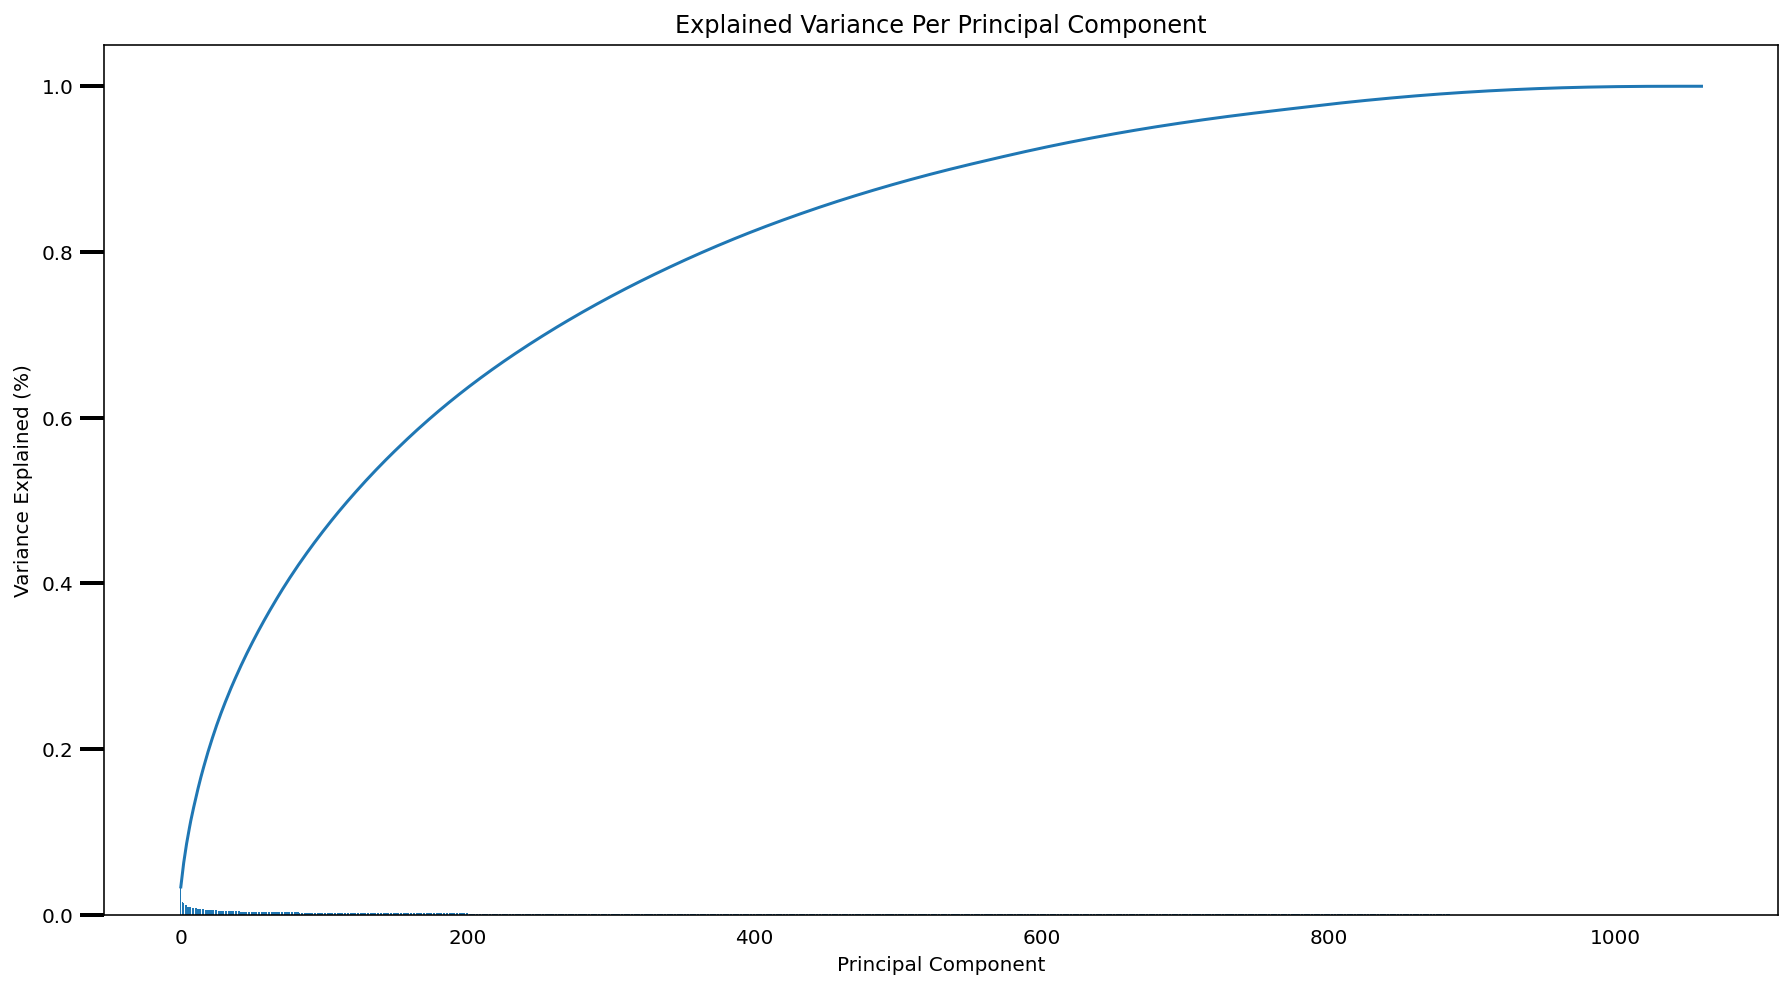

In [101]:
# To get the number of pca components to use (highest variance)
helper.scree_plot(pca)

In [102]:
# Re-apply PCA to the data while selecting for number of components to retain.

num_components=len(pca.explained_variance_ratio_)
vals = pca.explained_variance_ratio_

cumvals = np.cumsum(vals)
ind = next(x[0] for x in enumerate(cumvals) if x[1] > 0.8)
num_comps = ind+1
num_comps

print(f'{num_comps} PCA components --> allow us to capture {round(cumvals[num_comps-1]*100,2)}% of data variability')

366 PCA components --> allow us to capture 80.07% of data variability


In [103]:
pca = PCA(n_components=num_comps)
X_business_pca = pca.fit_transform(X_business)

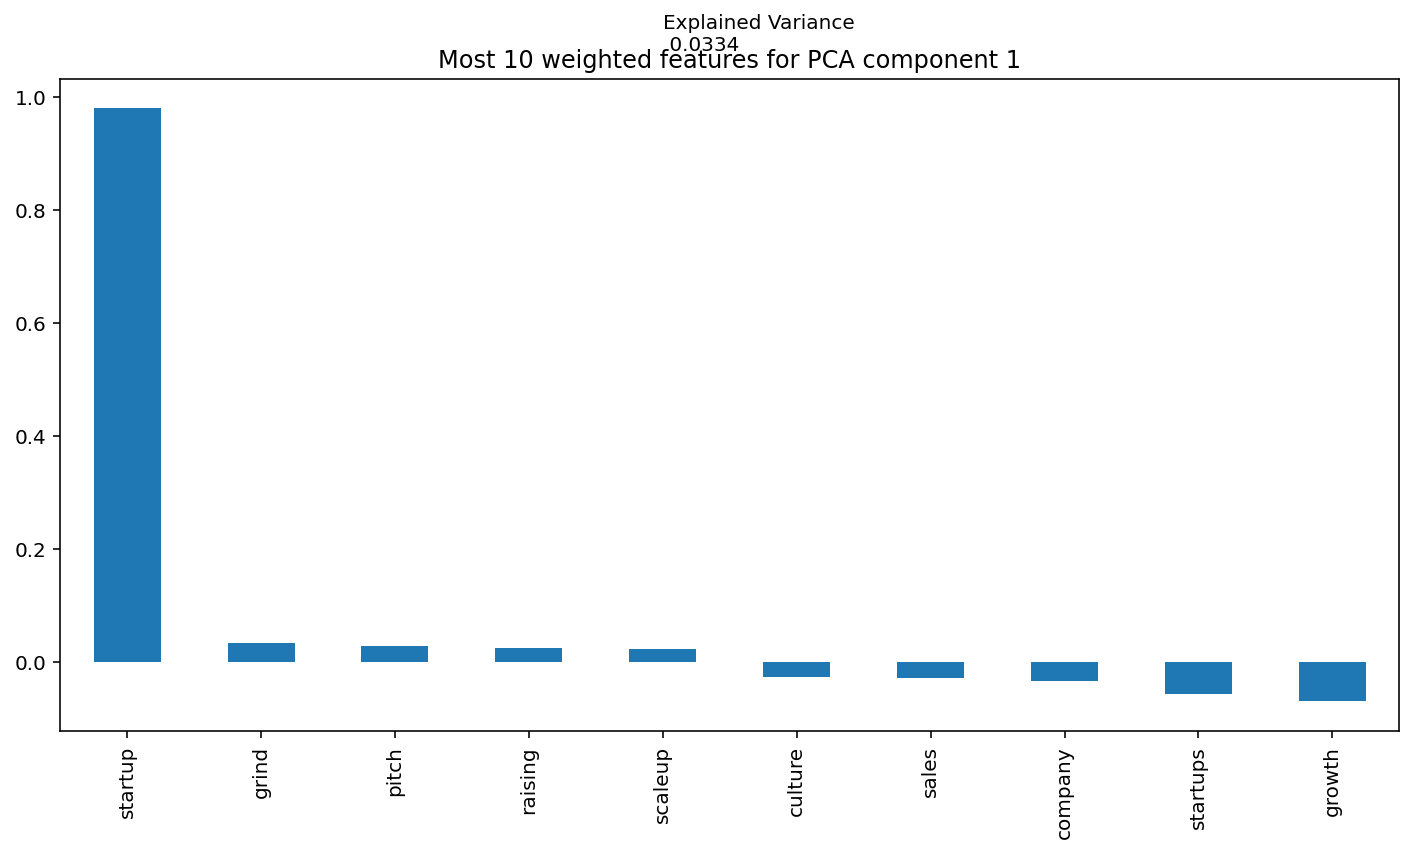

startup     0.9794
grind       0.0329
pitch       0.0283
raising     0.0241
scaleup     0.0226
culture    -0.0267
sales      -0.0292
company    -0.0340
startups   -0.0568
growth     -0.0703
Name: 0, dtype: float64


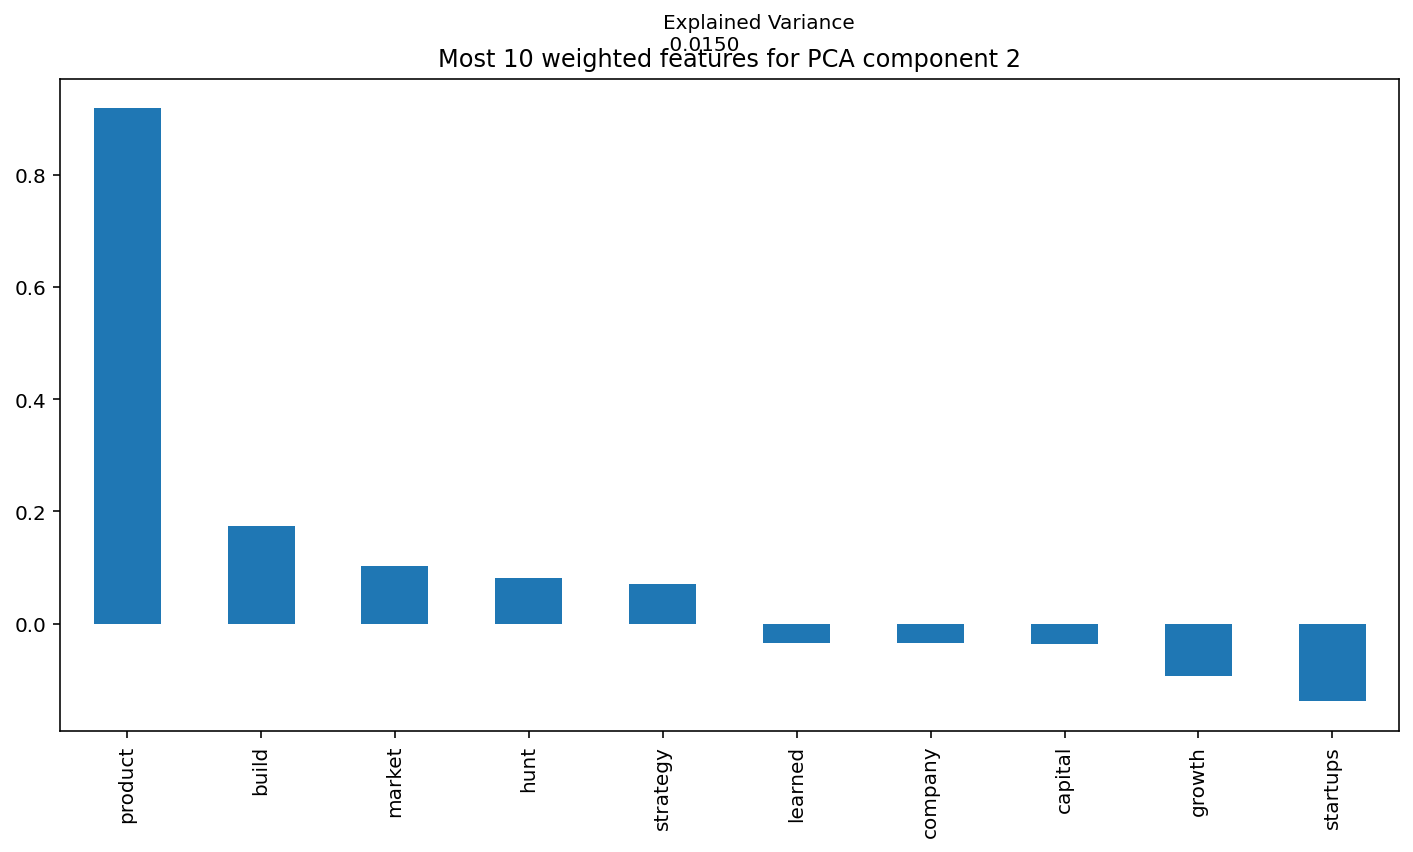

product     0.9182
build       0.1743
market      0.1036
hunt        0.0814
strategy    0.0708
learned    -0.0335
company    -0.0340
capital    -0.0368
growth     -0.0934
startups   -0.1382
Name: 1, dtype: float64


In [104]:
# Interpret Principal Components

res = helper.pca_results(X_business, pca, 1, 5)
print(res)

res = helper.pca_results(X_business, pca, 2, 5)
print(res)

<br>

## Clustering (Startup & Business)

In [105]:
# # Create a toy dataset to reduce computation time
# # Reduce the size to 25%
# X_pca_sample = X_pca[np.random.choice(X_pca.shape[0], int(df.shape[0]*0.25), replace=False)]

In [106]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...   
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
t0 = time()

sse = [] # Sum of Squared Errors
silhouette = []
calinski = []
k_range = np.arange(2, 21)

for k in k_range:
    kmeans = KMeans(k, random_state=42) # , max_iter=30
    model = kmeans.fit(X_business)
    preds = model.predict(X_business)
    # Scoring
    sil_score = silhouette_score(X_business, preds) #, metric='cosine'
    calinski_score = calinski_harabasz_score(X_business, preds)
    score = np.abs(model.score(X_business))
    sse.append(score)
    silhouette.append(sil_score)
    calinski.append(calinski_score)
    # Print Results
    print('Clustering done for {} k, with SSE {}'.format(k, round(score, 2)))
    print("For n_clusters = {}, silhouette score is {})".format(k, round(sil_score, 2)))
    print("For n_clusters = {}, calinski_harabasz score is {})".format(k, round(calinski_score, 2)))
    print('-'*50)
    
   
print((time()-t0)/60)

Clustering done for 2 k, with SSE 4773.69
For n_clusters = 2, silhouette score is 0.03)
For n_clusters = 2, calinski_harabasz score is 34.32)
--------------------------------------------------
Clustering done for 3 k, with SSE 4718.89
For n_clusters = 3, silhouette score is 0.04)
For n_clusters = 3, calinski_harabasz score is 23.49)
--------------------------------------------------
Clustering done for 4 k, with SSE 4705.76
For n_clusters = 4, silhouette score is 0.04)
For n_clusters = 4, calinski_harabasz score is 16.67)
--------------------------------------------------
Clustering done for 5 k, with SSE 4699.83
For n_clusters = 5, silhouette score is -0.01)
For n_clusters = 5, calinski_harabasz score is 12.84)
--------------------------------------------------
Clustering done for 6 k, with SSE 4644.03
For n_clusters = 6, silhouette score is 0.03)
For n_clusters = 6, calinski_harabasz score is 12.92)
--------------------------------------------------
Clustering done for 7 k, with SSE 

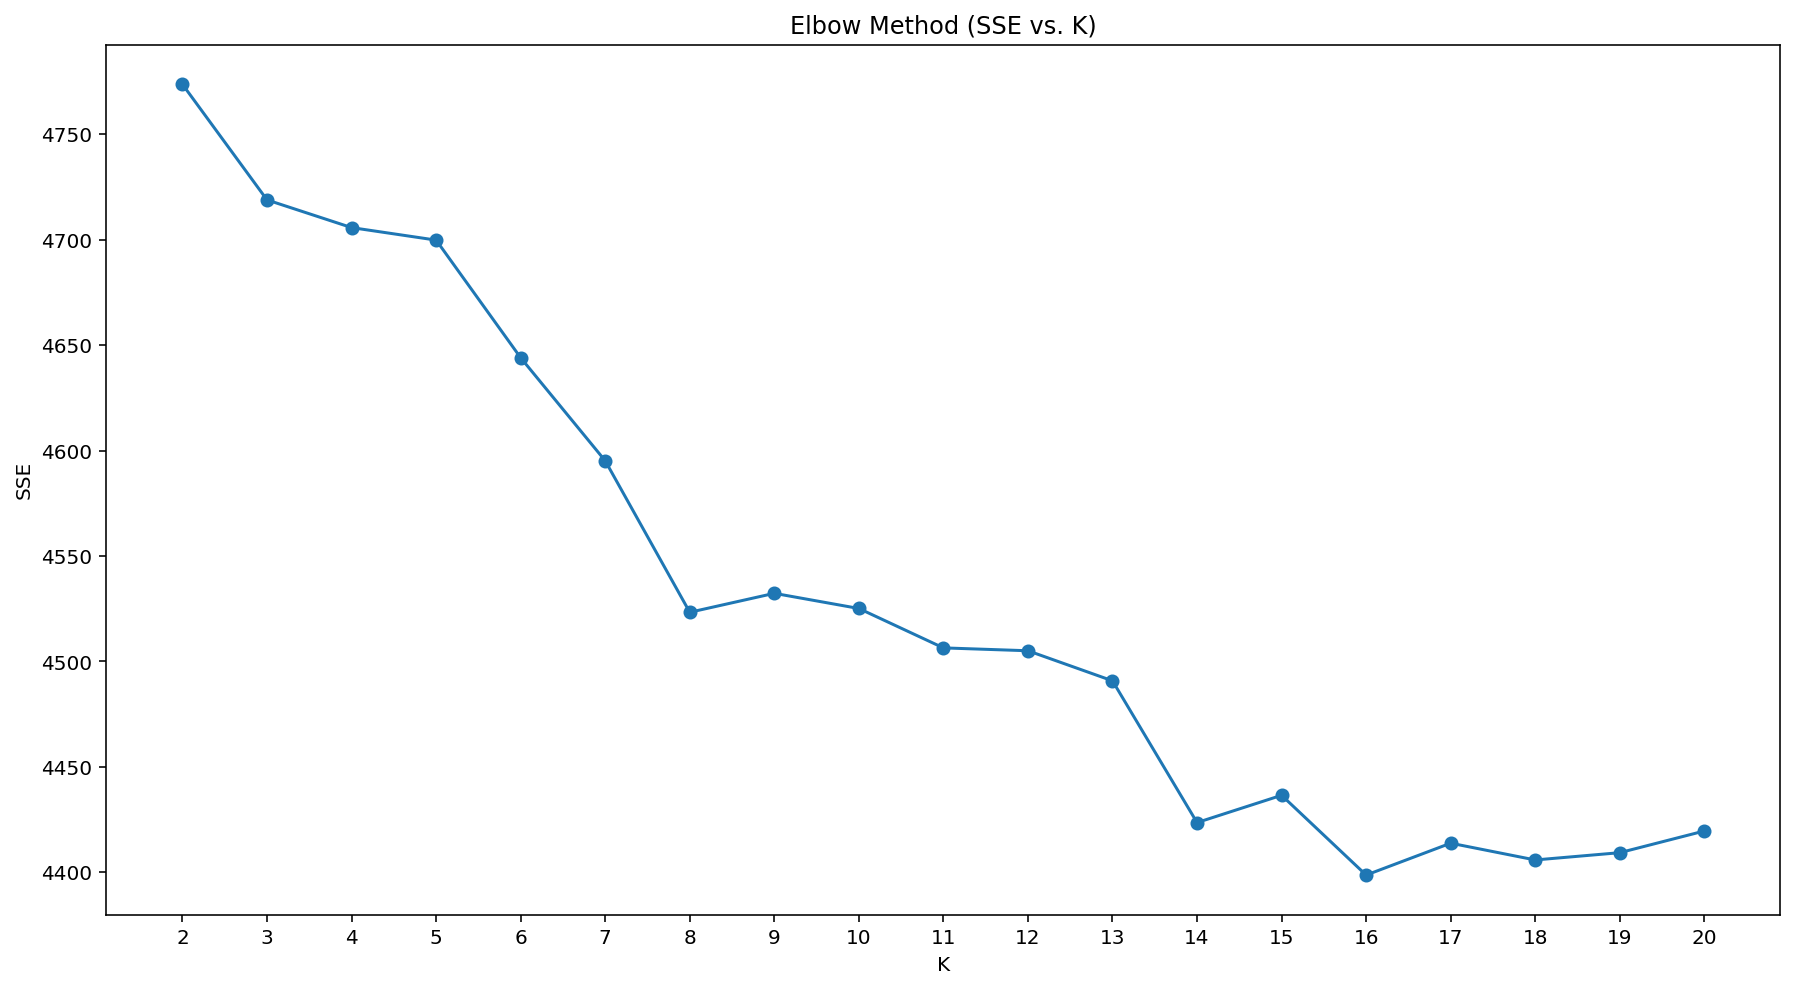

In [107]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Use the Elbow Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method (SSE vs. K)')
plt.plot(k_range, sse, linestyle='-', marker='o');

## Clustering Validation (Startups & Business)

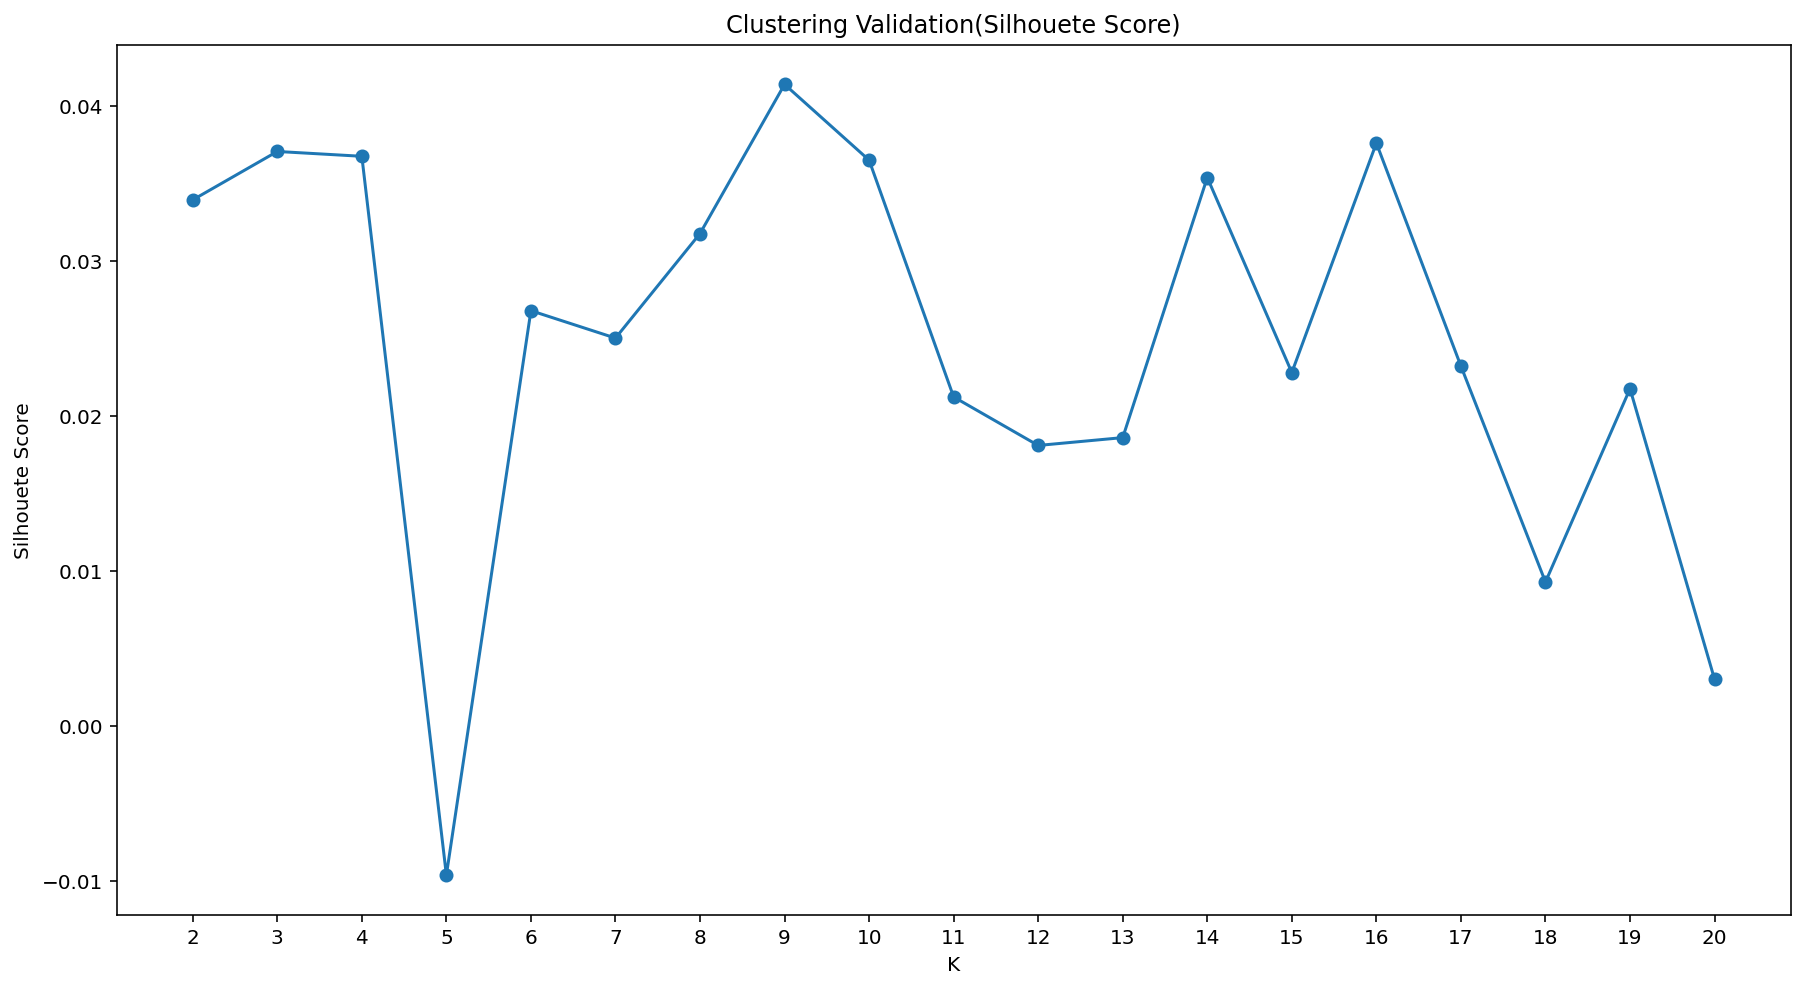

In [108]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('Silhouete Score')
plt.title('Clustering Validation(Silhouete Score)')
plt.plot(k_range, silhouette, linestyle='-', marker='o');

> **NOTE:**
> - Silhouete Score suggests k=3, k=4 or k=9.

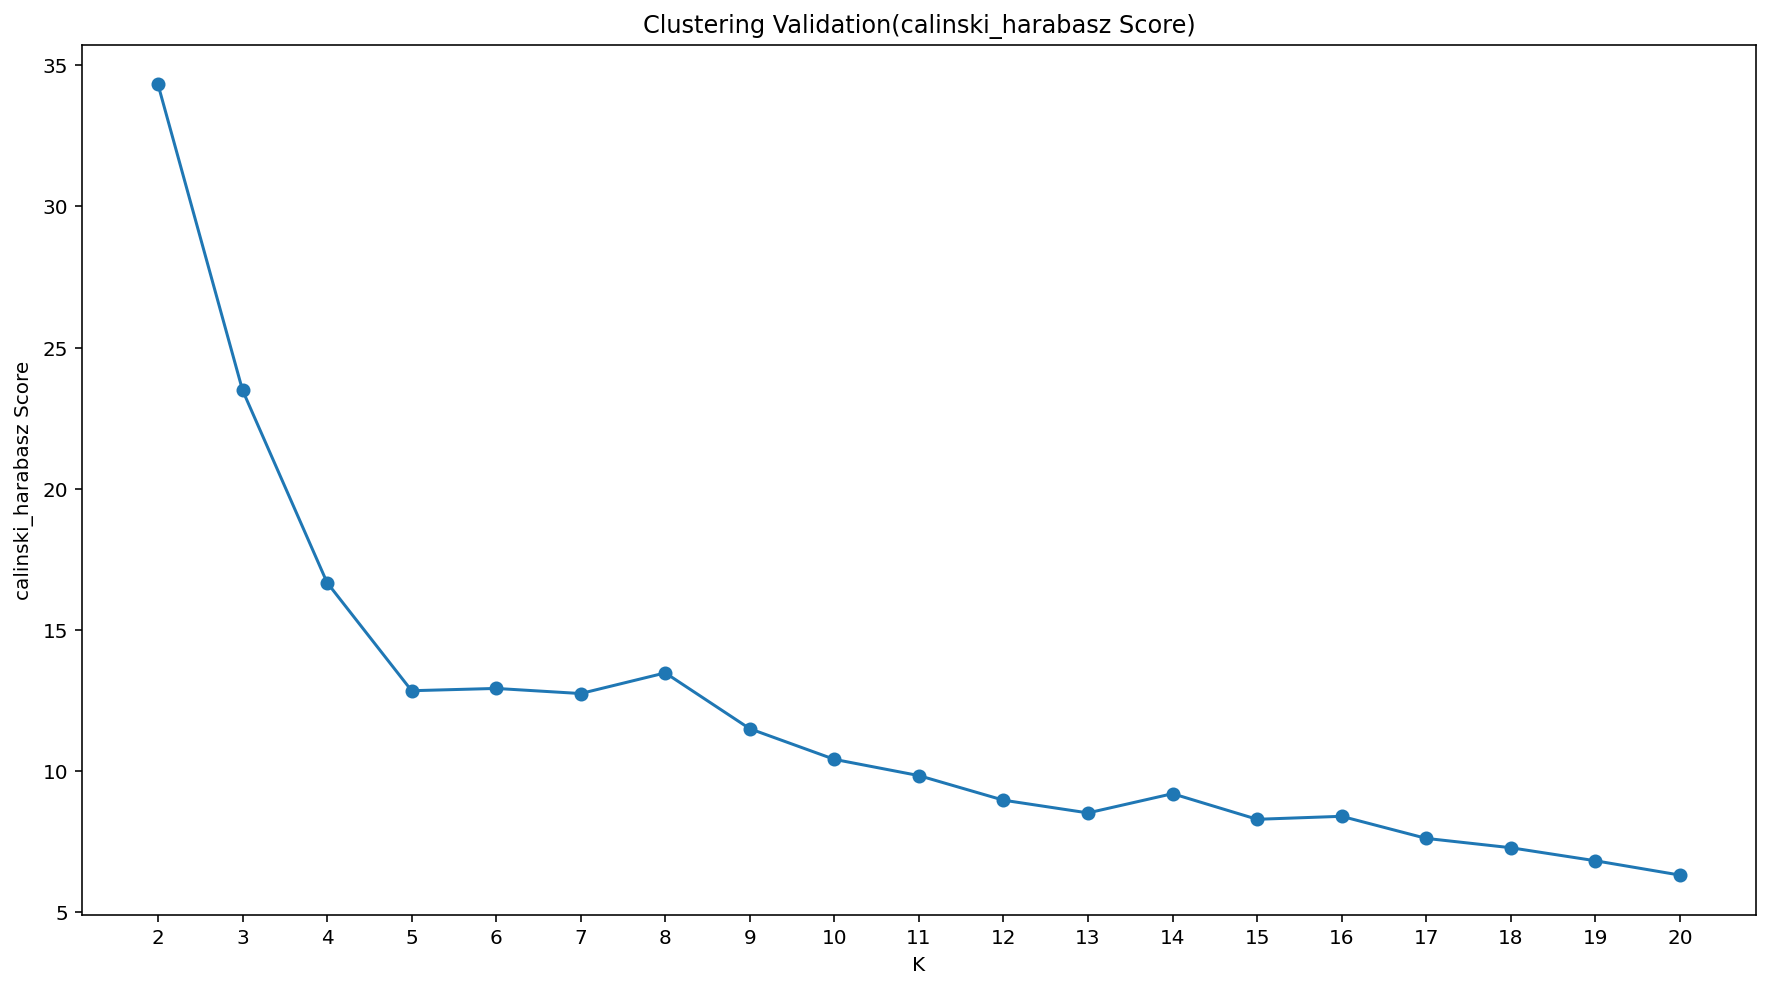

In [109]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('calinski_harabasz Score')
plt.title('Clustering Validation(calinski_harabasz Score)')
plt.plot(k_range, calinski, linestyle='-', marker='o');

In [146]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
t0 = time()

kmeans_3 = KMeans(n_clusters=3, random_state=42)
model_st = kmeans_3.fit(X_business)
clusters_business = model_st.predict(X_business)

print(time()-t0)

0.5727570056915283


In [147]:
# clusters_business 

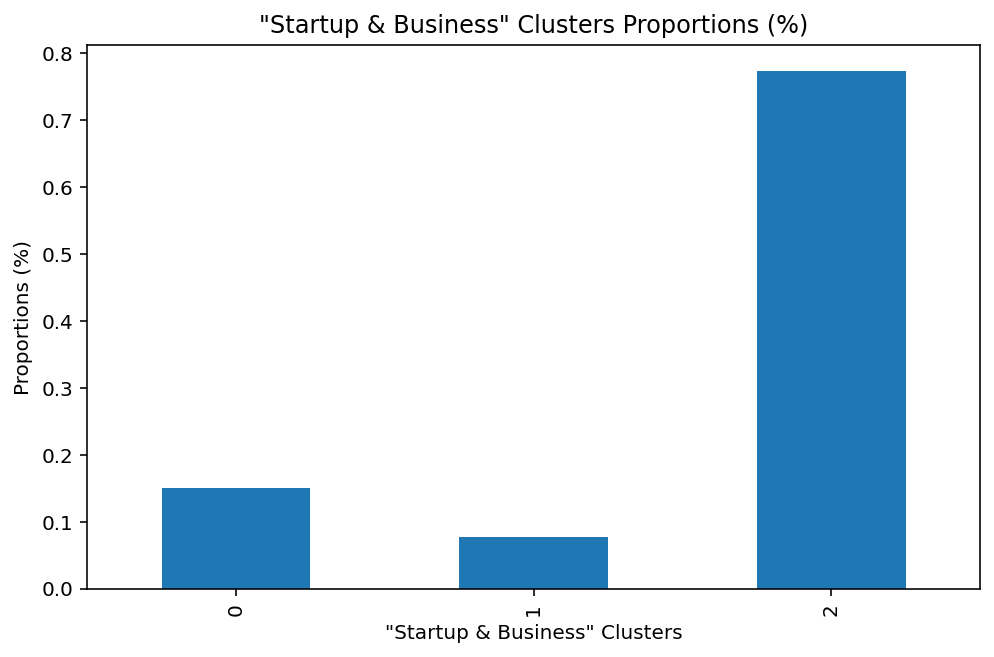

In [148]:
# Compare the proportion of data in each cluster 

# _c --> count, st --> startup
clusters_st_c = pd.Series(clusters_business).value_counts().sort_index()

# Calculate proprotions
prop_st = clusters_st_c / clusters_st_c.sum()

# PLOT
plt.figure(figsize=(8, 5))
prop_st.plot.bar(); # .sort_values(ascending=False)
plt.title('"Startup & Business" Clusters Proportions (%)')
plt.xlabel('"Startup & Business" Clusters');
plt.ylabel('Proportions (%)');

> **NOTE:**
> - The majority of the Startup & Business articles falls into one cluster (2).

**Get the most important features(words) for cluster (0)**

In [113]:
centroid_st_0 = pd.Series(model_st.cluster_centers_[0]).sort_values(ascending=False)
centroid_st_0.head(10)

2844    1.050314
2296    0.050314
2193    0.044025
328     0.044025
1161    0.037736
246     0.037736
1279    0.031447
2580    0.031447
1921    0.031447
2389    0.031447
dtype: float64

In [114]:
# Got an index error --> because we should locate columns and not rows
print(X_business.shape)
X.iloc[0, np.r_[tuple(centroid_st_0.head(10).index)]].index.to_list()

(1061, 3358)


['startup',
 'product',
 'pitch',
 'build',
 'founder',
 'best',
 'grind',
 'saas',
 'money',
 'raising']

> **NOTE:**
> - cluster (0) --> mapped into **Startup Growth**

<br>

**Get the most important features(words) for cluster (1)**

In [115]:
centroid_st_1 = pd.Series(model_st.cluster_centers_[1]).sort_values(ascending=False)
centroid_st_1.head(10)

1286    0.731707
2975    0.365854
330     0.109756
2590    0.060976
2296    0.060976
2616    0.048780
1681    0.048780
338     0.048780
2884    0.048780
1875    0.048780
dtype: float64

In [116]:
# Got an index error --> because we should locate columns and not rows
print(X_business.shape)
X.iloc[0, np.r_[tuple(centroid_st_1.head(10).index)]].index.to_list()

(1061, 3358)


['growth',
 'team',
 'building',
 'sales',
 'product',
 'scaling',
 'lessons',
 'business',
 'strategy',
 'million']

> **NOTE:**
> - cluster (1) --> mapped into **Start Startup**

<br>

**Get the most important features(words) for cluster (2)**

In [117]:
centroid_st_2 = pd.Series(model_st.cluster_centers_[2]).sort_values(ascending=False)
centroid_st_2.head(10)

2845    0.062195
2296    0.062195
516     0.046341
338     0.041463
2590    0.040244
1681    0.034146
1789    0.031707
655     0.031707
1294    0.031707
1762    0.029268
dtype: float64

In [118]:
# Got an index error --> because we should locate columns and not rows
print(X_business.shape)
X.iloc[0, np.r_[tuple(centroid_st_2.head(10).index)]].index.to_list()

(1061, 3358)


['startups',
 'product',
 'company',
 'business',
 'sales',
 'lessons',
 'marketing',
 'customer',
 'guide',
 'make']

> **NOTE:**
> - cluster (2) --> mapped into **Startup Mistakes & Lessons**

## Save Startup & Business Clusters

In [157]:
df.category.value_counts()

Startups & Business    1061
Product & Design        846
Engineering             547
Name: category, dtype: int64

In [158]:
startup_clusters = df[['body', 'title', 'category']].query(" category == 'Startups & Business' ")
startup_clusters['sub_category'] = clusters_business
startup_clusters['sub_category'] = startup_clusters.sub_category.map({0: 'startup_1', 1: 'startup_2', 2: 'startup_3'})
print(startup_clusters.shape)
print(f'Value Counts:\n{startup_clusters.sub_category.value_counts()}')
startup_clusters.head(1)


(1061, 4)
Value Counts:
startup_3    820
startup_1    159
startup_2     82
Name: sub_category, dtype: int64


,body,title,category,sub_category
0,The Founder Institute’s “Startup Tips and Tric...,Make Your Entrepreneurial Journey Sufficientl...,Startups & Business,startup_3


In [159]:
startup_clusters.to_json('Clustered_Subcategories/startup_clusters.json')

<br>

<br>

**Recommendation based on book title**

In [119]:
'startup & business'.title()

'Startup & Business'

In [120]:
data = df.loc[df['category'] == 'Engineering']  
data.reset_index(level = 0, inplace = True)
data.head(1)

,index,body,title,category,title_clean,body_clean
0,1,JAXenter: Have microservices helped you achiev...,"""The size of a microservice is the size of the...",Engineering,size microservice size team building,jaxenter microservices helped achieve goals av...


In [121]:
indices = pd.Series(data.index, index = data['title'])
indices.head()

title
"The size of a microservice is the size of the team that is building it"    0
"Transition to microservices while running under full steam is not easy"    1
10 JavaScript concepts every Node.js programmer must master | InfoWorld     2
10 Languages That Compile to JavaScript                                     3
10 Lessons in Microservices: a Utopian Mystery                              4
dtype: int64

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [149]:
# # Function for recommending books based on Book title. It takes book title and genre as an input.

# def recommend(title, category):
    
#     # Matching the genre with the dataset and reset the index
#     data = df.loc[df['category'] == category]  
#     data.reset_index(level = 0, inplace = True) 
  
#     # Convert the index into series
#     indices = pd.Series(data.index, index = data['title'])
    
#     #Converting the book title into vectors and used bigram
#     # (2, 2) means only bigrams, (1, 2) means unigrams and bigrams
#     tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), stop_words='english')
#     tfidf_matrix = tf.fit_transform(data['title'])
    
#     # Calculating the similarity measures based on Cosine Similarity
#     sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
#     # Get the index corresponding to original_title
       
#     idx = indices[title]# Get the pairwsie similarity scores 
#     sig = list(enumerate(sg[idx]))# Sort the books
#     sig = sorted(sig, key=lambda x: x[1], reverse=True)# Scores of the 5 most similar books 
#     sig = sig[1:6]# Book indicies
#     movie_indices = [i[0] for i in sig]
   
#     # Top 5 book recommendation
#     rec = data[['title', 'url']].iloc[movie_indices]
       
#     # It reads the top 5 recommended book urls and print the images
    
#     for i in rec['url']:
#         response = requests.get(i)
#         img = Image.open(BytesIO(response.content))
#         plt.figure()

<br>

<a id='end'></a>

<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end"><b>End of Notebook</b></a></li>  
</ul>

# End of Notebook

<br>